#  Прогнозирование заказов такси

## Описание проекта

Таксомоторная компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

### Цель проекта

Построить модель для предсказания количества заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Задачи проекта

1. Загрузить данные и выполнить их ресемплирование по одному часу.

2. Проанализировать данные. Определить подходящие прогнозирующие признаки для обучения моделей.

3. Обучить разные модели с различными гиперпараметрами. Выбрать лучшую прогнозную модель.

4. Проверить качество лучшей модели на тестовой выборке размером 10% от исходных данных.

### Описание данных

Данные находятся в файле [`/datasets/taxi.csv`](https://<LINK_REMOVED>/datasets/taxi.csv). 

`num_orders` — количество заказов.

## Установка и обновление библиотек

In [1]:
# обновляем версии библиотек и устанавливаем дополнительные библиотеки
%pip install matplotlib==3.5.0 scikit-learn==1.4.0 shap==0.46.0 \
    lightgbm==4.3.0 catboost==1.2.3 -q

Note: you may need to restart the kernel to use updated packages.


## Импорты

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split, 
    ParameterGrid,
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    root_mean_squared_error, 
    make_scorer
)
# классы моделей
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

## Настройки

In [3]:
# фиксируем случайное состояние для воспроизводимости результатов
RANDOM_STATE = 42

In [4]:
# отображать таблицы pandas полностью
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# размер графика по умолчанию
plt.rcParams['figure.figsize'] = (12, 5)

## Пользовательские функции и классы

In [6]:
def plot_seasonal_decompose(decomposed, ylabel='Количество'):
    """
    Строит графики составляющих сезонной декомпозиции: 
    тренд, сезонность и остаток.
    """
    # создаём область построения графиков
    fig, axes = plt.subplots(3, 1, figsize=(10, 9), constrained_layout=True)

    # строим графики
    decomposed.trend.plot(ax=axes[0])
    axes[0].set_title('Тренд')
    
    decomposed.seasonal.plot(ax=axes[1])
    axes[1].set_title('Сезонность')
    
    decomposed.resid.plot(ax=axes[2])
    axes[2].set_title('Остаток')

    for ax in axes:
        ax.set_xlabel('Дата и время')
        ax.set_ylabel(ylabel)

    return fig, axes

In [7]:
def corr_matrix(data, features=None, method='pearson', interval_cols=None):
    """
    Выводит матрицу корреляции количественных признаков features в данных data
    в виде тепловой карты.
    Дополнительный параметр:
    method - метод расчёта корреляции, по умолчанию 'pearson':
        'pearson' - корреляция Пирсона, 
        'spearman' - корреляция Спирмена,
        'kendall' - корреляция Кендалла,
        'phik' - корреляция фи.
    """
    if method == 'pearson':
        method_name = 'Пирсона'
    elif method == 'spearman':
        method_name = 'Спирмена'
    elif method == 'kendall':
        method_name = 'Кендалла'
    elif method == 'phik':
        method_name = '$\phi_k$'
    else:
        print('Неправильно указан метод расчёта корреляций.')
        return None

    if features is None:
        features = data.columns
         
    # расчёт матрицы корреляции
    if method in [ 'pearson', 'spearman', 'kendall']:
        corr_data = data[features].corr(method=method)
        vmin = -1
        vmax = 1
        center = 0
        cmap='bwr'
    elif method == 'phik':
        corr_data = data[features].phik_matrix(interval_cols=interval_cols)
        vmin = 0
        vmax = 1
        center = 0.5
        cmap='Greens'
    
    # строим тепловую карту по матрице корреляции
    ax = sns.heatmap(corr_data, 
                     annot=True,
                     fmt='.2f',
                     square=True,
                     cmap=cmap, 
                     vmin=vmin,
                     vmax=vmax,
                     center=center,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Коэффициенты корреляции {method_name}')

    return ax

In [8]:
def get_estimator_name(estimator):
    """
    Возвращает название класса модели, в том числе когда модель в пайплайне.
    """
    name = estimator.__class__.__name__
    
    return name if name != 'Pipeline' else estimator[-1].__class__.__name__

In [9]:
class SimpleGridSearch():
    """
    Класс для поиска оптимальных значений гиперпараметров модели
    по заданной валидационной выборке без применения кросс-валидации.
    """
    def __init__(self, 
                 estimator, 
                 parameters, 
                 *, 
                 scoring=None, 
                 refit=True,
                 verbose=0
    ):
        """Конструктор класса."""
        # модель
        self.estimator = clone(estimator)
        # сетка значений параметров для перебора
        self.param_grid = ParameterGrid(parameters)
        # оцениваемая метрика для максимизации
        self.scorer_ = scoring if scoring is not None else estimator.score  
        # флаг переобучения модели на всей выборке
        self.refit = refit
        # уровень вывода
        self.verbose = verbose

    def fit(self, X, y, **fit_params):
        """
        Поиск оптимальных значений гиперпараметров модели.
        Дополнительный параметр: 
        eval_set - валидационная выборка - кортеж (X, y)
        """
        # модель
        estimator = clone(self.estimator)
        # начальные параметры модели
        init_params = estimator.get_params()
        # сетка значений параметров для перебора
        param_grid = self.param_grid
        # оцениваемая метрика для максимизации
        scorer = self.scorer_

        # валидационная выборка
        X_eval, y_eval = fit_params.pop('eval_set', (X, y))
        # количество шагов
        num_fits = len(param_grid)
        
        scores = []
        for i, param in enumerate(param_grid): 
            if get_estimator_name(estimator).startswith('CatBoost'):
                estimator = clone(estimator)
            # задаём гиперпараметры модели
            estimator.set_params(**param)
            # обучаем модель
            estimator.fit(X, y, **fit_params)
            # считаем метрику на валидационной выборке
            score = scorer(estimator, X_eval, y_eval)
            
            scores.append(score)

            if self.verbose > 0:
                print(
                    f'Fit {i+1:>{len(str(num_fits))}} of {num_fits}. '
                    f'Parameters: {param}, '
                    f'score: {score}'
                )
        # максимальное значение метрики
        best_score = max(scores)
        # лучшие параметры модели
        best_params = param_grid[scores.index(best_score)]
        
        self.best_score_ = best_score
        self.best_params_ = best_params
        # лучшая модель
        if self.refit:
            self.best_estimator_ = (
                clone(estimator)
                .set_params(**init_params)
                .set_params(**best_params)
                .fit(X, y, **fit_params)
            )

        return self

    def predict(self, X):
        """
        Предсказания лучшей модели.
        """
        return self.best_estimator_.predict(X)

In [10]:
def get_nondefault_params(estimator, base_estimator):
    """
    Возвращает словарь с гиперпараметрами модели 'estimator', которые 
    отличаются от значений для базовой модели 'base_estimator'.
    """
    # извлекаем модель из пайплайна
    if estimator.__class__.__name__ == 'Pipeline':
        estimator = estimator[-1]
    # параметры модели
    params = estimator.get_params()
    # параметры базовой модели
    default_params = base_estimator.get_params()

    nondefault_params = {key: value for key, value in params.items() 
                         if params.get(key) != default_params.get(key)}

    # возвращает None, если словарь 'nondefault_params' пустой
    return nondefault_params or None

In [11]:
def plot_residuals(y_test, y_pred):
    """
    Строит графики для визуального анализа остатков:
    - гистограмму распределения остатков,
    - диаграмму рассеяния остатков и предсказаний модели.
    """
    # остатки модели
    residuals = y_test - y_pred
    # среднее значение остатков
    residuals_mean = residuals.mean()

    # создаём область построения графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)
    
    # строим гистограмму распределения остатков
    sns.histplot(x=residuals, ax=axes[0], kde=True)
    axes[0].axvline(x=residuals_mean, color='red', label='Среднее значение:\n'+str(residuals_mean.round(4)))
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество')
    axes[0].legend()
    
    # строим диаграмму рассеяния остатков и предсказаний модели
    sns.residplot(x=y_pred, y=residuals, ax=axes[1], lowess=True, line_kws=dict(color="r"))
    axes[1].set_xlim(axes[1].get_xlim() * np.array([0.99, 1.01]))
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    
    # заголовок
    fig.suptitle('Анализ остатков')

    return fig, axes

In [12]:
def plot_feature_importance(importance, feature_names):
    """
    Строит график важности признаков.
    """
    # формируем таблицу
    feature_df = (
        pd.DataFrame({'признак': feature_names, 'значение': importance})
        .sort_values(by='значение', key=lambda x: abs(x), ascending=False)
        .reset_index(drop=True)
    )
    # визуализируем данные в таблице
    sns.barplot(data=feature_df, x='значение', y='признак')

## Подготовка данных

### Загрузка данных

При загрузке данных из CSV-файла укажем аргументы `index_col = 0` и `parse_dates=[0]`, чтобы привести первый столбец к типу `datetime64` и установить его в качестве индекса.

In [13]:
# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
    source = 'по умолчанию'
elif os.path.exists(path_local):
    path = path_local_rel
    source = 'локальный путь'
else:
    path = path_remote
    source = 'сетевой путь'
    
# загрузка данных из CSV файла
data = pd.read_csv(path + 'taxi.csv', index_col=0, parse_dates=[0])

print(f'Данные успешно загружены из источника: {source}: {path}')

Данные успешно загружены из источника: локальный путь: ~/datasets/


### Знакомство с данными

In [14]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные содержат только один столбец `num_orders` — количество заказов. Это и есть целевой признак для прогнозирования.

Полезно сохранить название целевого признака для прогнозирования в отдельную переменную `target_col`.

In [15]:
# название целевого признака
target_col = 'num_orders'

Судя по информации выше, пропущенные значения в данных отсутствуют. Убедимся в этом.

In [16]:
print('Количество пропущенных значений:', 
      data[target_col].isna().sum())

Количество пропущенных значений: 0


Выясним, за какой период данные.

In [17]:
print('Данные за период с {} по {}.'.format(
    data.index.min(), data.index.max()
))

Данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.


Проверим уникальность и монотонность значений индекса.

In [18]:
print('Значения индекса уникальны:',
    data.index.is_unique)
print('Значения индекса упорядочены по возрастанию:',
    data.index.is_monotonic_increasing)

Значения индекса уникальны: True
Значения индекса упорядочены по возрастанию: True


Посмотрим на первые записи в данных.

In [19]:
# первые 10 строк таблицы
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Убедимся, что записи следуют с одинаковым интервалом и найдём его значение. Судя по таблице выше, это 10 минут. 

In [20]:
print('Интервал между значениями индекса одинаковый:',
      data.index
      .to_series()
      .diff()
      .nunique() == 1
     )
print('Интервал между значениями индекса:',
      data.index
      .to_series()
      .diff()
      .dropna()
      .unique()[0]
      .astype('timedelta64[m]')
     )

Интервал между значениями индекса одинаковый: True
Интервал между значениями индекса: 10 minutes


Проверим данные о количестве заказов на наличие аномальных значений.

In [21]:
# статистические характеристики числовых признаков
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Посмотрим, не является ли аномалией максимальное значение. Для этого отсортируем данные по убыванию количества заказов.

In [22]:
# сортируем данные по убыванию количества заказов,
# выводим первые 10 записей
data.sort_values(by=target_col, ascending=False).head(10)

,num_orders
datetime,
2018-08-27 02:10:00,119
2018-08-13 02:20:00,119
2018-08-13 02:30:00,99
2018-08-27 02:00:00,98
2018-08-30 17:50:00,95
2018-08-20 02:20:00,94
2018-08-20 04:00:00,91
2018-08-20 02:10:00,90
2018-08-20 02:00:00,87


Для выявления аномалий построим гистограмму распределения количества заказов за 10 минут.

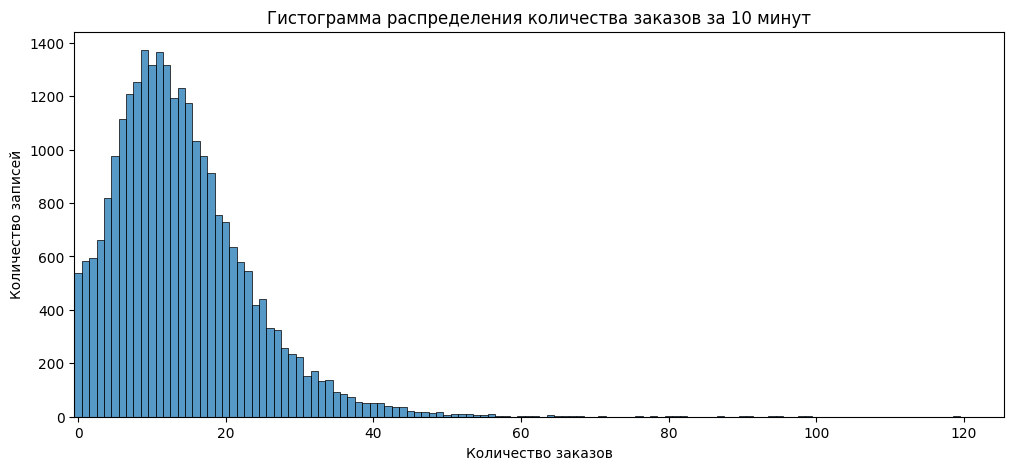

In [23]:
# создаём область построения графиков
plt.figure(figsize=(12, 5))

# строим график
ax = sns.histplot(data[target_col], discrete=True)

# оформляем график
plt.xlim(-0.5)
plt.xlabel('Количество заказов')
plt.ylabel('Количество записей')
plt.title('Гистограмма распределения количества заказов за 10 минут');

Получается, что 119 заказов за 10 минут — это не аномалия, а просто очень редкое явление. Это значение встречается в данных дважды, а следующее за ним — 99.

### Ресемплирование временного ряда

Выполним ресемплирование данных по одному часу — посчитаем суммарное количество заказов за каждый час.

In [24]:
# выполняем ресемплирование данных
data = data.resample('1H').sum()

# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В результате в данных теперь всего 4416 записей о количестве заказов в течение каждого часа за период с начала марта по конец августа 2018 года включительно. 

### Выводы

1. Исходные данные загружены, проверены на корректность, наличие дубликатов, пропущенных значений и аномалии.
    - Исходный датасет содержит данные о количестве заказов такси в течение каждых 10 минут за полгода, с начала марта по конец августа 2018 года включительно.
    - Дубликаты, пропущенные и аномальные значения в данных отсутствуют.
      
2. Выполнено ресемплирование данных по одному часу. В результате получен временной ряд с суммарным количеством заказов за каждый час за период с 0 часов 1 марта по 23 часа 31 августа 2018 года включительно.

## Анализ данных

### Анализ стационарности

Исследуем временной рад на стационарность. Построим его график, для большей наглядности добавив скользящее среднее и скользящее стандартное отклонение значений ряда.

In [25]:
# добавляем скользящее среднее по 24 часам
data['rolling_mean_24'] = data[target_col].rolling(24).mean()

# добавляем скользящее стандартное отклонение по 24 часам
data['rolling_std_24'] = data[target_col].rolling(24).std()

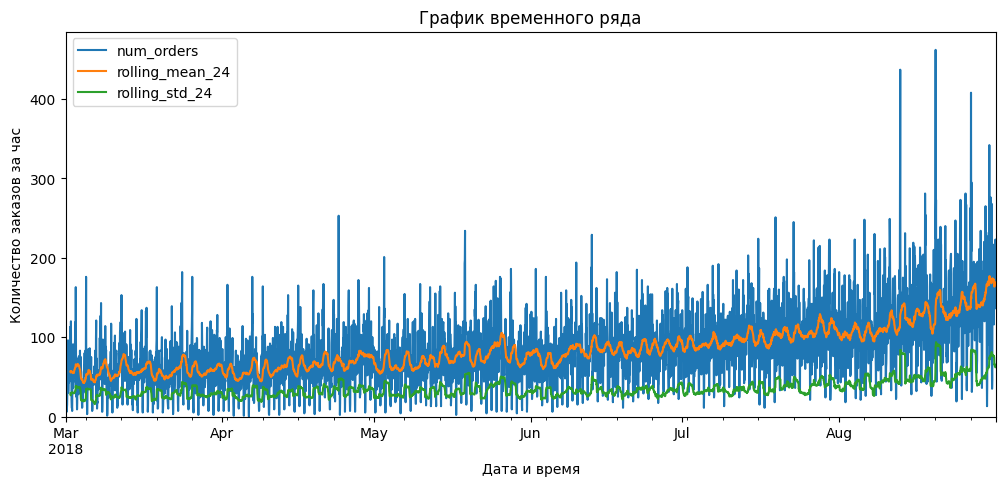

In [26]:
# строим график
data.plot()

# оформляем график
plt.ylim(0)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов за час')
plt.title('График временного ряда');

По графику видно, что временной ряд — нестационарный: среднее значение и стандартное отклонение значений ряда со временем возрастают. Изменение со временем среднего значения означает, что у временного ряда имеется тренд.

### Анализ сезонности

Выделим тренд и сезонность из временного ряда. Визуализируем компоненты сезонного разложения временного ряда с помощью пользовательской функции `plot_seasonal_decompose`.

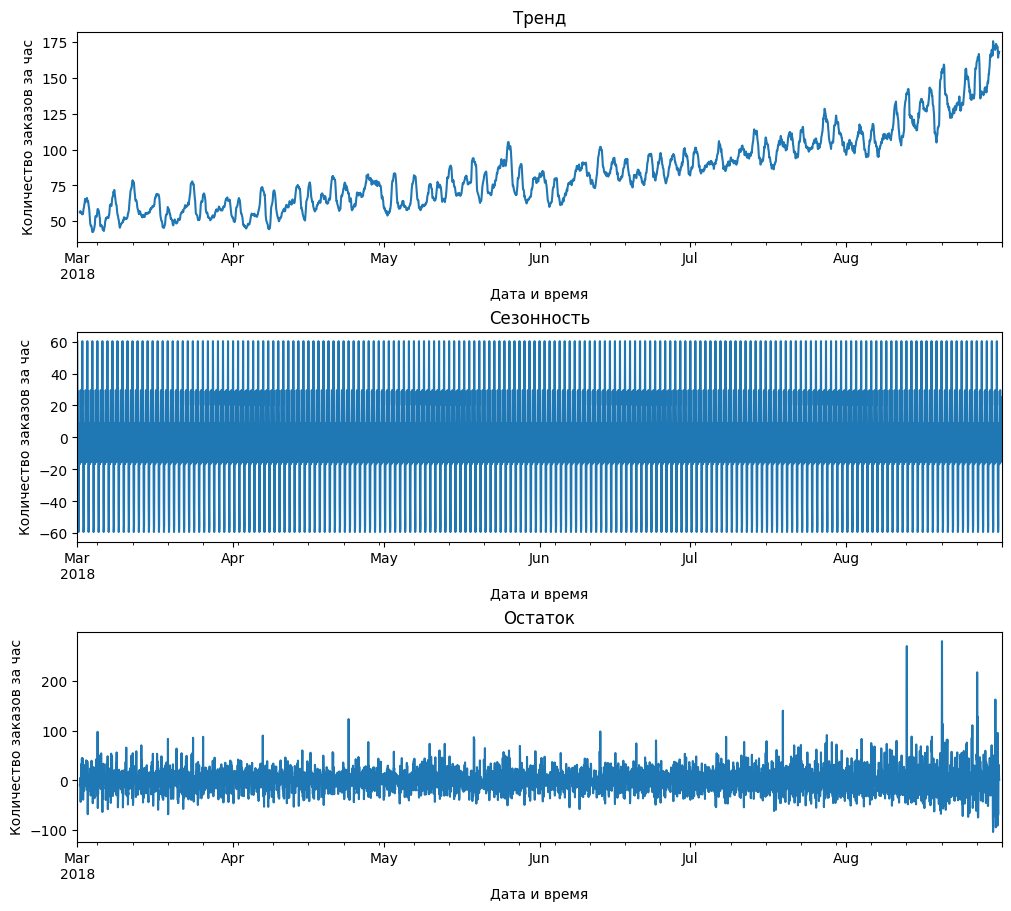

In [27]:
# выполняем декомпозицию ряда на тренд, сезонную компоненту и остатки
decomposed = seasonal_decompose(data[target_col])

# строим графики
plot_seasonal_decompose(decomposed, ylabel='Количество заказов за час');

Рассмотрим подробнее сезонную компоненту ряда. По графику видно, что она имеет короткий период, поэтому построим её график на интервале 2 недели.

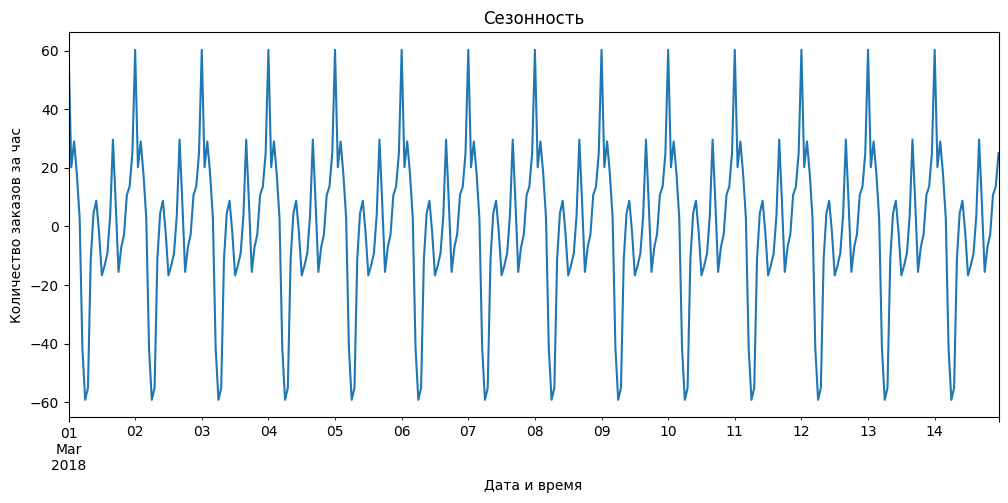

In [28]:
# строим график
decomposed.seasonal['2018-03-01':'2018-03-14'].plot()

# оформляем график
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов за час')
plt.title('Сезонность');

Из графика выше очевидно, что период сезонной компоненты составляет 1 сутки, т.е. 24 часа. 

Построим график сезонной компоненты за один суточный период.

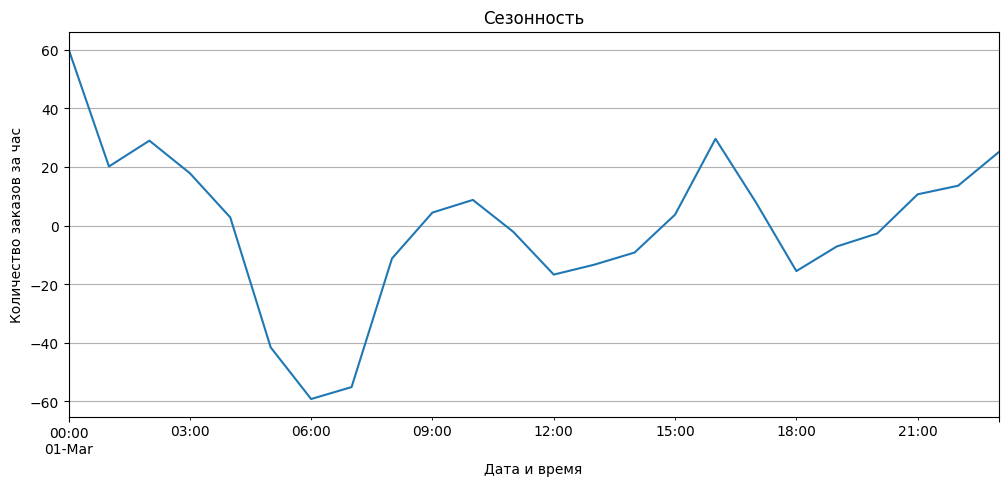

In [29]:
# строим график
decomposed.seasonal['2018-03-01'].plot(grid=True)

# оформляем график
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов за час')
plt.title('Сезонность');

Получается, что в среднем пик заказов такси в аэропортах приходится на полночь, и в целом спрос на такси выше поздним вечером и ночью — с 21 часа до 4 часов ночи. Вероятная причина этого в том, что в это время количество прибывающих рейсов ещё велико, а общественный транспорт ходит реже, чем в дневные часы.

Наименьший спрос на такси ранним утром — с 5 до 7 часов утра.

В течение дня наблюдаются пики в районе 9-10 часов и в 16 часов — вероятно, это утренний и вечерний час-пик, когда число прибывающих в аэропорт рейсов максимально. А между ними в интервале 12-14 часов наблюдается провал спроса на такси.

Известно, что `seasonal_decompose` настраивается на сезонность с самым маленьким циклом. Выясним, есть ли в данных кроме суточной ещё и недельная сезонность. Для этого выполним ресемплирование данных по суткам, а затем снова сделаем декомпозицию на сезонность и тренд.

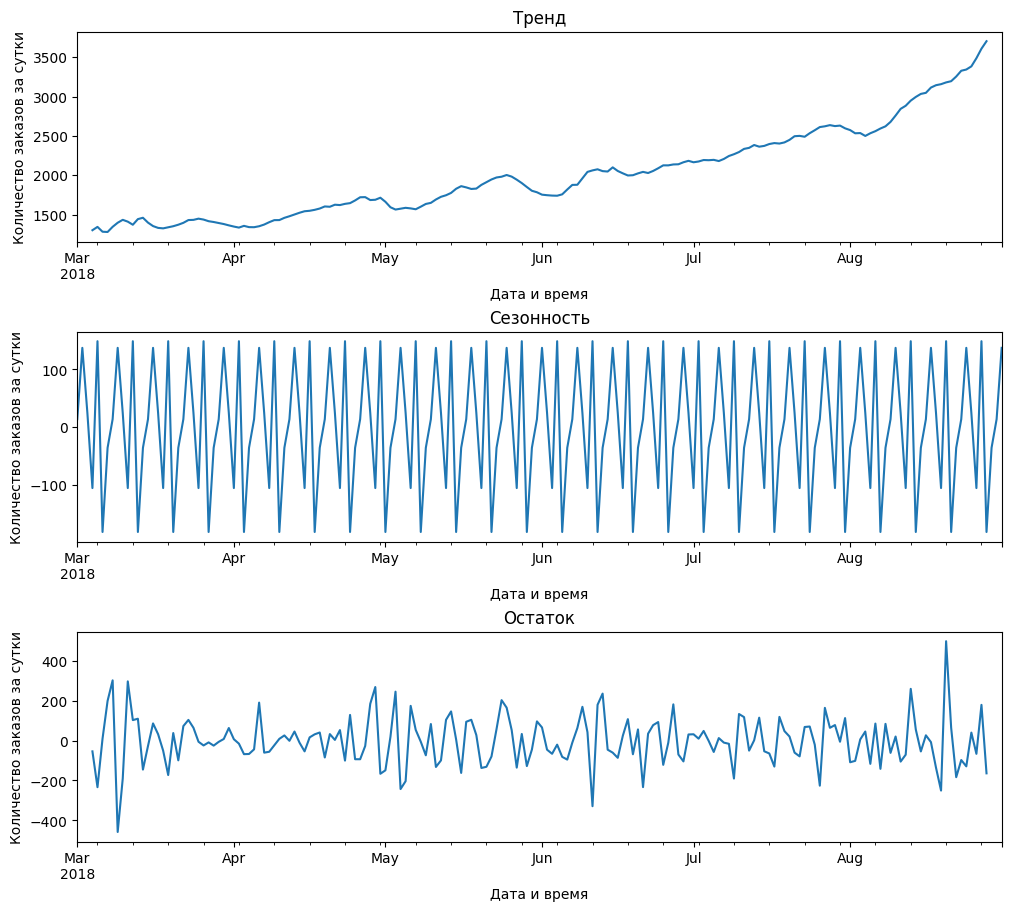

In [30]:
# выполняем ресемплирование данных
data_ = data.resample('1D').sum()

# выполняем декомпозицию ряда на тренд, сезонную компоненту и остатки
decomposed_ = seasonal_decompose(data_[target_col])

# строим графики
plot_seasonal_decompose(decomposed_, ylabel='Количество заказов за сутки');

Построим график сезонности заказов по дням недели за период одного месяца.

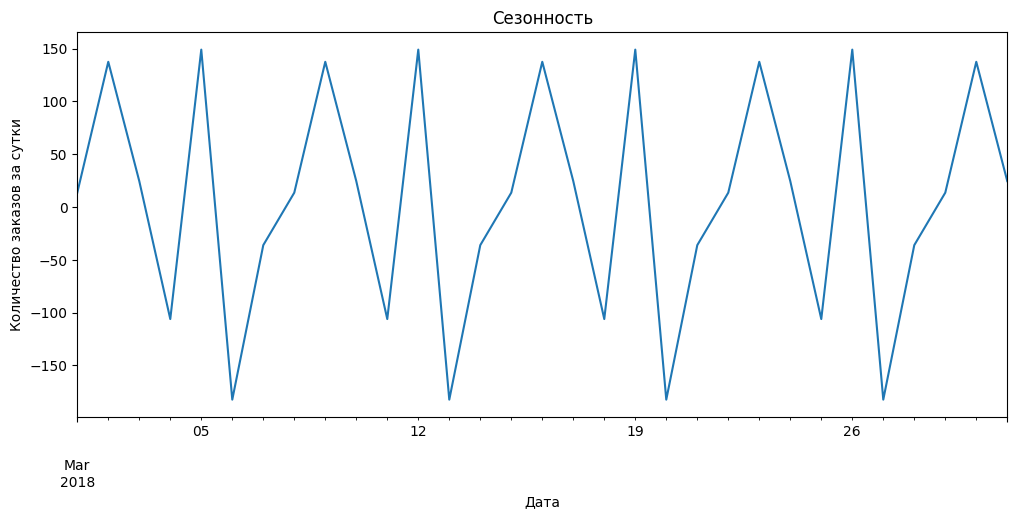

In [31]:
# строим график
decomposed_.seasonal['2018-03-01':'2018-03-31'].plot()

# оформляем график
plt.xlabel('Дата')
plt.ylabel('Количество заказов за сутки')
plt.title('Сезонность');

Действительно, период сезонной компоненты составляет 7 дней, т.е. одну неделю.

### Анализ автокорреляции

Для определения зависимости между количеством заказов такси за текущий час и за предшествующие часы исследуем автокорреляцию временного ряда, которая показывает, насколько значения ряда коррелируют с его значениями в предшествующие моменты времени. Прямую линейную связь между значениями ряда и его предыдущими значениями с определенным лагом, исключая вклады промежуточных лагов, покажет *частичная автокорреляция*.

Исследование частичной автокорреляции временного ряда поможет выбрать наиболее релевантные запаздывающие признаки для прогнозирования значений ряда.

Построим график функции частичной автокорреляции — *коррелограмму*, с помощью функции `plot_pacf` из модуля `statsmodels.graphics.tsaplots`.

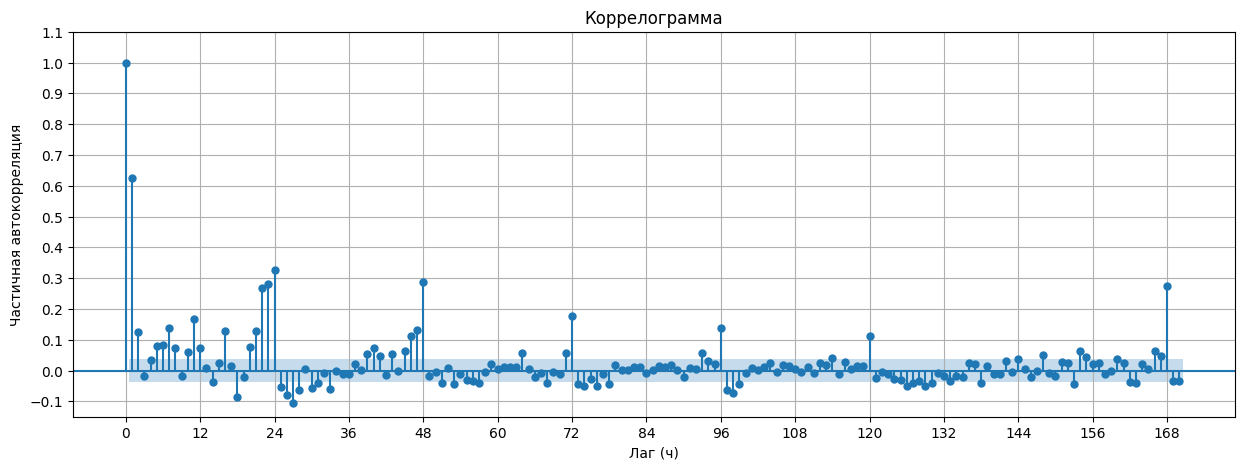

In [32]:
# создаём область построения графиков
fig, ax = plt.subplots(figsize=(15, 5))

# строим график
plot_pacf(data[target_col], lags=170, alpha=0.01, method='ywm', ax=ax)

# оформляем график
plt.ylim([-0.15, 1.05])
plt.xticks(range(0, 175, 12))
plt.yticks(np.arange(-0.1, 1.1, 0.1))
plt.xlabel('Лаг (ч)')
plt.ylabel('Частичная автокорреляция')
plt.title('Коррелограмма')
plt.grid()
plt.show()

По графику видно, что количество заказов такси за текущий час сильнее всего коррелирует с количеством заказов за предшествующий час, а также с количеством заказов в этот же час дня 1, 2, 3 и т.д. суток назад. При этом корреляция текущего значения ряда и его значения в это же время неделю назад даже больше, чем для его значения трое суток назад.

Рассмотрим функцию частичной автокорреляции временного ряда на большем промежутке, построив её значения с интервалом 1 сутки, т.е. 24 часа.

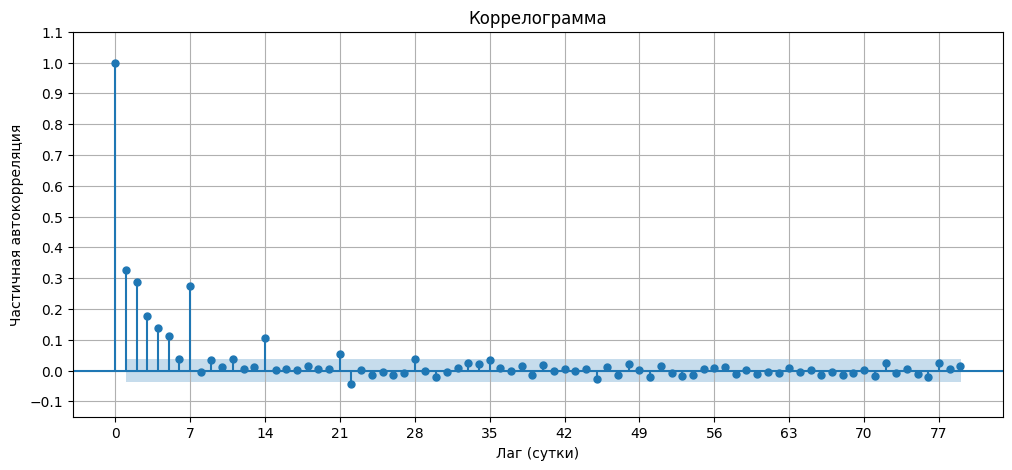

In [33]:
# создаём область построения графиков
fig, ax = plt.subplots()

# строим график
plot_pacf(data[target_col], lags=np.arange(80)*24, alpha=0.01, method='ywm', ax=ax)

# оформляем график
plt.ylim([-0.15, 1.05])
plt.xticks(range(0, 81*24, 7*24), labels=range(0, 81, 7))
plt.yticks(np.arange(-0.1, 1.1, 0.1))
plt.xlabel('Лаг (сутки)')
plt.ylabel('Частичная автокорреляция')
plt.title('Коррелограмма')
plt.grid()
plt.show()

Получается, что значения временного ряда заметно коррелированы с его значениями с лагами 7, 14 и 21 сутки, кратными неделе.

### Добавление признаков

#### Календарные признаки

Добавим в данные календарные признаки, которые можно извлечь из индекса — шкалы даты-времени:
- `month` — месяц: от 3 (март) до 8 (август);
- `day` — день: от 1 до 30 или 31 в зависимости от месяца;
- `dayofweek` — день недели: от 0 (понедельник), до 6 (воскресенье);
- `hour` — час: от 0 до 23.

К сожалению, неизвестно, в какой стране собраны данные, поэтому добавить признак "Выходной день или праздник" нельзя, т.к. в зависимости от страны выходные дни могут приходиться на разные дни недели.

In [34]:
# добавляем столбцы в таблицу
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour

# выводим первые 5 записей
data.head()

,num_orders,rolling_mean_24,rolling_std_24,month,day,day_of_week,hour
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,0
2018-03-01 01:00:00,85,NaN,NaN,3,1,3,1
2018-03-01 02:00:00,71,NaN,NaN,3,1,3,2
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,3
2018-03-01 04:00:00,43,NaN,NaN,3,1,3,4


Исследуем зависимость количества заказов от календарных признаков с среднем за весь период. Для этого сгруппируем данные по значению признака и найдём среднее значение временного ряда в группе.

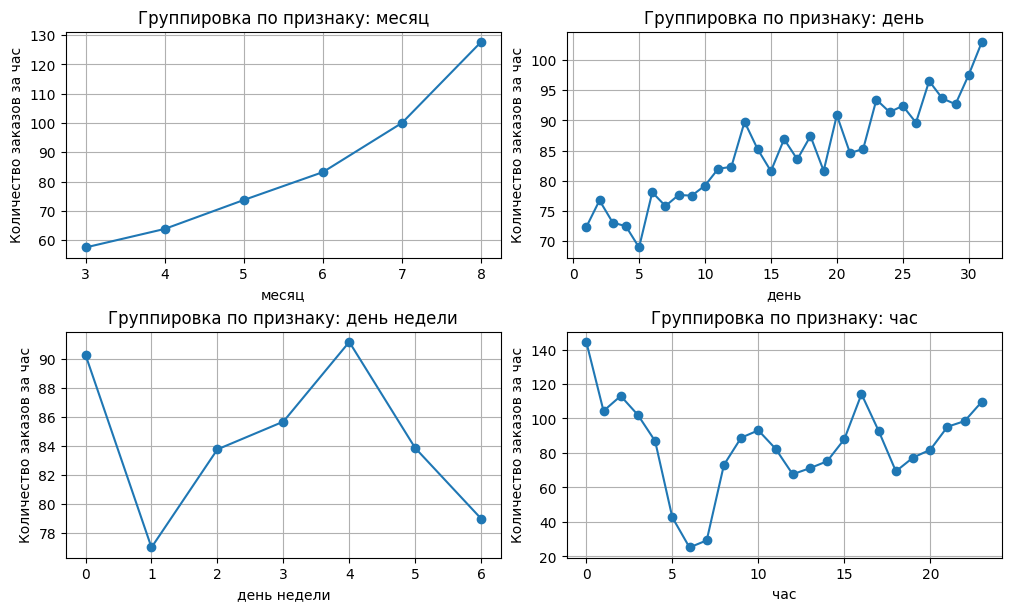

In [35]:
# список календарных признаков
features = ['month', 'day', 'day_of_week', 'hour']
feature_names = ['месяц', 'день', 'день недели', 'час']

# создаём область построения графиков
nrows = (len(features) + 1) // 2
fig, axes = plt.subplots(nrows, 2, figsize=(10, 3*nrows), constrained_layout=True)
axes = axes.ravel()

# строим графики
for i, feature in enumerate(features):
    ax = axes[i]
    data.groupby(feature)[target_col].mean()\
        .plot(style='o-', grid=True, ax=ax)
    ax.set_title('Группировка по признаку: ' + feature_names[i])
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('Количество заказов за час')

Чтобы отделить закономерности, связанные с сезонностью от вызванных общим трендом, перед группировкой вычтем из данных скользящее среднее (тренд).

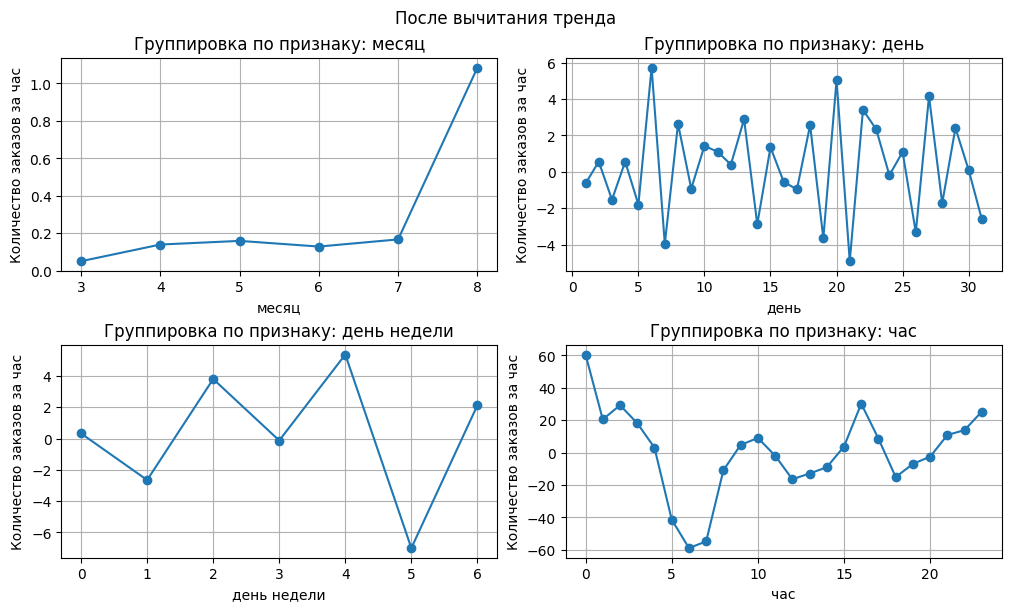

In [36]:
# вычитаем из данных тренд
data_detrended = data.copy()
data_detrended[target_col] = data[target_col] - data['rolling_mean_24']
data_detrended = data_detrended.dropna()

# создаём область построения графиков
nrows = (len(features) + 1) // 2
fig, axes = plt.subplots(nrows, 2, figsize=(10, 3*nrows), constrained_layout=True)
axes = axes.ravel()

# строим графики
for i, feature in enumerate(features):
    ax = axes[i]
    data_detrended.groupby(feature)[target_col].mean()\
        .plot(style='o-', grid=True, ax=ax)
    ax.set_title('Группировка по признаку: ' + feature_names[i])
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('Количество заказов за час')
    
# заголовок графиков
fig.suptitle('После вычитания тренда');

По графикам видно, что после вычитания тренда зависимость среднего количества заказов от месяца практически полностью исчезла, а зависимость от дня месяца превратилась в шумоподобную. Это значит, что зависимость значений временного ряда от этих признаков была обусловлена его трендом.

Зависимость среднего количества заказов от дня недели и времени суток сохранилась, поскольку она обусловлена сезонностью.

Поскольку данные имеются только за 6 месяцев (с марта по август 2018 года), а в данных имеется возрастающий тренд, то сезонности по времени года в данных быть не может, поэтому признак "месяц" будет не информативным. Тренд временного ряда учтём далее с помощью скользящего среднего значения и запаздывающих значений. 

Также не была обнаружена сезонность по дню месяца, поэтому признак "день месяца" тоже окажется не информативным.

Исходя из этого, оставим в данных только следующие календарные признаки:
- `dayofweek` — день недели;
- `hour` — час,
а признаки `month` и `day` удалим.

In [37]:
# удаляем ранее добавленные признаки
data = data.drop(columns=['month', 'day'])

#### Скользящее среднее

Для учёта тренда временного ряда нужно добавить в данные новый прогнозирующий признак —  тренд после удаления сезонной компоненты с максимальным периодом. На этапе анализа сезонности был установлен факт недельной периодичности спроса на такси, поэтому в качестве прогнозирующего признака для учёта тренда временного ряда лучше выбрать скользящее среднее за период предшествующих 7 суток, т.е. $24 \times 7 = 168$ часов, но чтобы оно не включало в себя текущее значение ряда.

In [38]:
# удаляем ранее добавленные скользящие среднее и стандартное отклонение
data = data.drop(columns=['rolling_mean_24', 'rolling_std_24'])

In [39]:
# добавляем скользящее среднее за предшествующие 7 суток
data[target_col + '_weekly_avg'] = data[target_col].shift(1).rolling(24*7).mean()

#### Запаздывающие признаки

На этапе анализа автокорреляции временного ряда были проанализированы значения частичной автокорреляции значений временного ряда в предшествующие моменты времени с его текущим значением. Это позволяет выбрать в качестве прогнозирующих признаков запаздывающие признаки с величиной частичной автокорреляции, превышающей заданный порог, который выбирается эмпирическим путём.

Для учёта запаздывающих признаков при прогнозировании придётся удалить начальную часть данных, для которых они неизвестны, поэтому чтобы впоследствии не терять много данных из обучающей выборки, ограничимся добавлением признаков с максимальным лагом 1 неделя, т.е. $7 \times 24 = 168$ часов.

Установим значение порога 0.2. Такой выбор обеспечит баланс между сложностью модели и её точностью.

Добавим в данные запаздывающие признаки с помощью функции `add_lag_features`.

In [40]:
def add_lag_features(data, feature, lags):
    """
    Добавляет в данные 'data' запаздывающие значения признака 'feature' с задержками
    из списка 'lags'.
    """
    new_data = data.copy()
    for lag in lags:
        new_data['{}_lag_{}'.format(feature, lag)] = data[feature].shift(lag)

    return new_data

In [41]:
# максимальное количество лагов для расчёта частичной автокорреляции
max_lag = 24 * 30

# значения частичной автокорреляции
pacf_values = pacf(data[target_col], nlags=max_lag, method='ywm')

In [42]:
# пороговое значение частичной автокорреляции
pacf_threshold = 0.2

# выбираем лаги, где частичная автокорреляция превышает пороговое значение
lags = np.array(range(max_lag+1))[abs(pacf_values) > pacf_threshold][1:].tolist()
print('Отобранные лаги:', ', '.join(map(str, lags)), 'ч')

Отобранные лаги: 1, 22, 23, 24, 48, 168 ч


In [43]:
# добавляем запаздывающие признаки
data = add_lag_features(data, target_col, lags)

Посмотрим на структуру датасета после добавления новых признаков.

In [44]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_orders             4416 non-null   int64  
 1   day_of_week            4416 non-null   int64  
 2   hour                   4416 non-null   int64  
 3   num_orders_weekly_avg  4248 non-null   float64
 4   num_orders_lag_1       4415 non-null   float64
 5   num_orders_lag_22      4394 non-null   float64
 6   num_orders_lag_23      4393 non-null   float64
 7   num_orders_lag_24      4392 non-null   float64
 8   num_orders_lag_48      4368 non-null   float64
 9   num_orders_lag_168     4248 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 379.5 KB


### Разделение выборок

Разделим данные на **обучающую**, **валидационную** и **тестовую** выборки таким образом, чтобы размеры тестовой и валидационной выборки были одинаковы и составляли 10% от исходных данных.

Прогнозирующая модель сначала будет обучаться на **обучающей выборке**, предварительная оценка её качества и подбор гиперпараметров будет производиться с использованием **валидационной** выборки.

Затем модель будет снова обучена на **полной обучающей** выборке, т.е. на объединении обучающей и валидационной. Качество обученной модели будет проверено на **тестовой** выборке.

In [45]:
# разделяем данные на обучающую, валидационную и тестовую выборки
# в пропорции 80:10:10.
train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

# удаляем записи с пропущенными значениями признаков из обучающей выборки
train = train.dropna()

# после удаления пропущенных значений
# приводим запаздывающие признаки к типу int
lag_features = data.filter(like='_lag_').columns
for subset in [train, valid, test]:
    subset[lag_features] = subset[lag_features].astype('int')

# объединяем обучающую и валидационную выборки
train_valid = pd.concat([train, valid])

print('Размеры выборок:\n'
      'обучающая: {}, валидационная: {}, тестовая: {}\n'
      .format(len(train), len(valid), len(test))
     )
print('Границы выборок:')
display(
    pd.DataFrame(
        [
            ['train', train.index.min(), train.index.max()],
            ['valid', valid.index.min(), valid.index.max()],
            ['test', test.index.min(), test.index.max()]
        ],
        columns=['subset', 'min', 'max']
    ).set_index('subset')
)

Размеры выборок:
обучающая: 3364, валидационная: 442, тестовая: 442

Границы выборок:


,min,max
subset,,
train,2018-03-08 00:00:00,2018-07-26 03:00:00
valid,2018-07-26 04:00:00,2018-08-13 13:00:00
test,2018-08-13 14:00:00,2018-08-31 23:00:00


Размеры тестовой и валидационной выборки одинаковы, диапазоны индекса выборок не пересекаются и следуют друг за другом в правильном порядке.

Выделим добавленные ранее прогнозирующие признаки и целевой признак `num_orders` (количество заказов такси за час) в отдельные переменные для каждой из выборок с помощью функции `split_target`.

In [46]:
def split_target(data, target_col):
    """
    Выделяет прогнозирующие признаки и целевой признак в отдельные переменные.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    return X, y

In [47]:
# отделяем целевой признак для всех выборок
X_train, y_train = split_target(train, target_col)
X_valid, y_valid = split_target(train, target_col)
X_train_valid, y_train_valid = split_target(train_valid, target_col)
X_test, y_test = split_target(test, target_col)

### Анализ корреляций признаков

Исследуем степень связи прогнозирующих признаков друг с другом и c целевым признаком, построив матрицу корреляций.

Исследование корреляций признаков поможет выявить различия попарных совместных распределений признаков между выборками и обнаружить мультиколлинеарность между прогнозирующими признаками, которая негативно влияет на интерпретируемость моделей, а также на качество линейных моделей, особенно линейной регрессии.

Линейная регрессия ищет в данных линейные зависимости между входными признаками и целевым. Степень линейной связи между количественными признаками покажет корреляция Пирсона.

Для каждой созданной выборки рассчитаем матрицу корреляции признаков и визуализируем её в виде тепловой карты с помощью пользовательской функции `corr_matrix`.

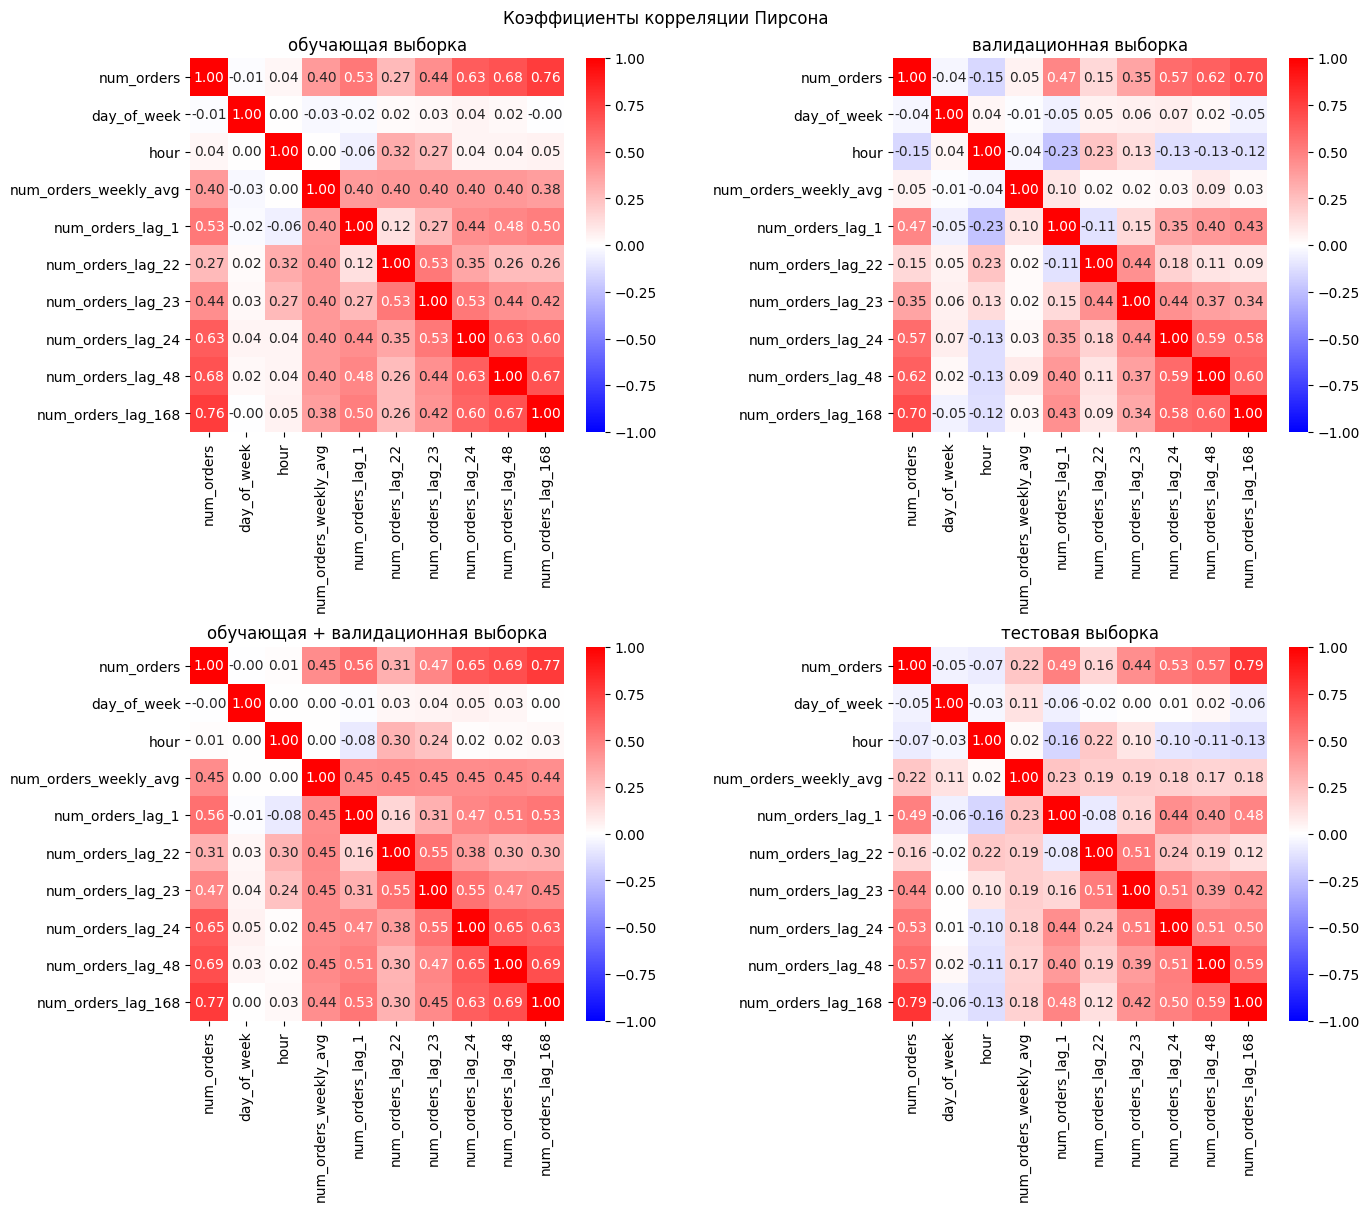

In [48]:
# создаём область построения графиков
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 12), constrained_layout=True)
axes = axes.ravel()

# строим матрицу корреляции для всех выборок
for i, (subset, subset_name) in enumerate(zip(
    [train, valid, train_valid, test],
    ['обучающая', 'валидационная', 'обучающая + валидационная', 'тестовая']
)):
    ax = axes[i]
    plt.sca(ax)
    corr_matrix(subset, method='pearson')
    title = ax.get_title()
    ax.set_title(subset_name +' выборка')

# заголовок графиков
fig.suptitle(title);

Видно, что коэффициенты корреляции между признаками в данных значительно варьируются для разных выборок. Причина этого — нестационарность временного ряда, из которого получены признаки. Из-за этого качество моделей на тестовой выборке может оказаться ниже, чем на валидационной.

Однако можно отметить, что коэффициенты корреляции между запаздывающими признаками и целевым признаком для всех выборок изменяются не так сильно.

### Выводы

1. Установлено, что исследуемый временной ряд — нестационарный: среднее значение и стандартное отклонение значений ряда со временем возрастают. Изменение со временем среднего значения означает, что у временного ряда имеется тренд.

2. Выявлены сезонные компоненты временного ряда с суточной и недельной периодичностью, поэтому в качестве прогнозирующего признака для учёта тренда временного ряда следует выбрать скользящее среднее за период предшествующих 7 суток.

3. Исследование частичной автокорреляции временного ряда помогло выбрать наиболее релевантные запаздывающие признаки для прогнозирования будущих значений ряда — его значения с лагом 1 час, 22 и 23 часа, 1 сутки (24 часа), 2 суток (48 часов) и 1 неделя (168 часов), которые сильнее всего коррелируют с текущим значением ряда.

4. К данным добавлены прогнозирующие признаки, по которым ML модель будет предсказывать значения временного ряда:

    - **Календарные признаки**: день недели и час, которые позволят учесть выявленную суточную и недельную сезонность временного ряда. 
    - **Скользящее среднее значение** количества заказов в час за период предшествующих 7 суток (168 часов), которое позволит учесть тренд временного ряда.
    - **Запаздывающие признаки** — значения количества заказов в час с лагом 1 час, 22 и 23 часа, 1 сутки (24 часа), 2 суток (48 часов) и 1 неделя (168 часов).

5. Данные разделены на обучающую, валидационную и тестовую выборки с выделением целевого признака (количества заказов такси за час) в отдельную переменную. Размеры тестовой и валидационной выборки одинаковы и составляют по 10% от исходных данных. Предварительная оценка качества моделей и подбор гиперпараметров будет производиться с использованием валидационной выборки, а затем качество лучшей модели, обученной на полной обучающей выборке (т.е. на объединении обучающей и валидационной), будет проверено на тестовой выборке.

6. Анализ корреляций между признаками, проведённый отдельно для каждой из выборок, показал, что коэффициенты корреляции между признаками в данных значительно варьируются для разных выборок. Причина этого — нестационарность временного ряда. Из-за этого качество моделей на тестовой выборке может оказаться ниже, чем на валидационной.

## Обучение моделей

На этапе **настройки моделей** будем обучать модели на обучающей выборке и предварительно оценим качество их предсказаний на валидационной выборке. Также попробуем подобрать гиперпараметры моделей с использованием валидационной выборки.

На этапе **обучения моделей** все отобранные модели будут обучены на полной обучающей выборке (т.е. объединении обучающей и валидационной выборок), а качество их предсказаний будет проверено на тестовой выборке.

### Настройка моделей

#### Линейная регрессия

Первым делом рассмотрим самую простую модель — линейную регрессию.

Календарные признаки `day_of_week` (день недели) и `hour` (час) следует рассматривать как категориальные. Поэтому, чтобы их адекватно учитывали при обучении линейные модели, нужно применить к ним OHE-кодирование.

Кроме того, линейные модели требуют предварительного масштабирования количественных входных признаков. 

Поэтому для обучения модели линейной регрессии создадим пайплайн, включающий в себя:
- кодирование категориальных признаков `day_of_week` и `hour`  с помощью `OneHotEncoder`;
- стандартизацию количественных признаков (скользящего среднего и запаздывающих признаков) с помощью `StandardScaler`;
- собственно линейную регрессию `LinearRegression`.

In [49]:
# категориальные признаки для кодирования OneHotEncoder
cat_columns = [
    'day_of_week',
    'hour',
]

# количественные признаки для масштабирования - все остальные
num_columns = X_train.columns.drop(cat_columns).tolist()

# пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', 
                              handle_unknown='ignore', 
                              sparse_output=False), cat_columns),
        ('scaler', StandardScaler(), num_columns)
    ], 
    remainder='drop',
    verbose_feature_names_out=False,
)

# создаём пайплайн модели
linreg_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('estimator', LinearRegression())
])

# выводим списки входных признаков
print('Категориальные признаки для кодирования OneHotEncoder:', cat_columns)
print('Количественные признаки для масштабирования:', num_columns)
print('Пайплайн модели:')
linreg_pipe

Категориальные признаки для кодирования OneHotEncoder: ['day_of_week', 'hour']
Количественные признаки для масштабирования: ['num_orders_weekly_avg', 'num_orders_lag_1', 'num_orders_lag_22', 'num_orders_lag_23', 'num_orders_lag_24', 'num_orders_lag_48', 'num_orders_lag_168']
Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['day_of_week', 'hour']),
                                                 ('scaler', StandardScaler(),
                                                  ['num_orders_weekly_avg',
                                                   'num_orders_lag_1',
                                                   'num_orders_lag_22',
                                                   'num_orders_lag_23',
                                                   'num_orders_lag_24',
                                                   'num_orders_lag_48',
                                                   'num_orders_lag_168'])],
                                   verbose_feature_names_out=False)),
                ('estimator', LinearRegression())])

Для оценки качества предсказаний модели будем использовать метрику RMSE — среднеквадратичную ошибку предсказаний модели. Для удобства создадим скорер, который возвращает значение этой метрики для данной модели на заданной выборке. Поскольку более высокому качеству модели соответствуют меньшие значения RMSE, то скорер добавляет к ним знак "минус" для единообразия, т.к. при оптимизации модели принято максимизировать целевую метрику.

In [50]:
# скорер, который возвращает метрику RMSE модели со знаком "минус"
rmse_score = make_scorer(root_mean_squared_error, greater_is_better=False)

Обучим модель на обучающей выборке и оценим её качество на валидационной.

In [51]:
# обучаем модель на обучающей выборке
linreg_pipe.fit(X_train, y_train)

# считаем метрику RMSE на валидационной выборке
linreg_pipe_valid_score = -rmse_score(linreg_pipe, X_valid, y_valid)

print(f'Метрика RMSE модели на валидационной выборке: {linreg_pipe_valid_score:.2f}')

Метрика RMSE модели на валидационной выборке: 20.04


Значение RMSE на валидационной выборке ниже целевого уровня 48, однако, как показал ранее анализ корреляций признаков в разных выборках, значение RMSE на тестовой выборке может оказаться выше, поэтому нужно рассмотреть и другие модели, чтобы выбрать из них лучшую по качеству на валидационной выборке.

#### Модель опорных векторов

Рассмотрим более сложную регрессионную модель SVM, которая также является линейной, но за счёт выбора нелинейного ядра позволяет модели объяснять более сложные нелинейные зависимости в данных.

Также как и для модели линейной регрессии, подготовку данных для модели выполним в пайплайне. Чтобы не создавать пайплайн заново, скопируем пайплайн и изменим тип ML модели в нём на `SVR`.

In [52]:
# создаём пайплайн модели
svr_pipe = clone(linreg_pipe).set_params(estimator=SVR())

print('Пайплайн модели:')
svr_pipe

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['day_of_week', 'hour']),
                                                 ('scaler', StandardScaler(),
                                                  ['num_orders_weekly_avg',
                                                   'num_orders_lag_1',
                                                   'num_orders_lag_22',
                                                   'num_orders_lag_23',
                                                   'num_orders_lag_24',
                                                   'num_orders_lag_48',
                                                   'num_orders_lag_168'])],
                                   verbose_feature_names_out=False)),
                ('estimator', SVR())])

Обучим модель на обучающей выборке и оценим её качество на валидационной.

In [53]:
# обучаем модель на обучающей выборке
svr_pipe.fit(X_train, y_train)

# считаем метрику RMSE на валидационной выборке
svr_pipe_valid_score = -rmse_score(svr_pipe, X_valid, y_valid)

print(f'Метрика RMSE модели на валидационной выборке: {svr_pipe_valid_score:.2f}')

Метрика RMSE модели на валидационной выборке: 21.58


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить меньшее значение метрики RMSE на валидационной выборке. Для модели `SVR` подберём тип ядра — параметр `kernel`, степень `degree` для полиномиального ядра `kernel='poly'` и параметр регуляризации `C`.

Для поиска оптимального набора гиперпараметров используем полный перебор по сетке, т.к. количество возможных сочетаний невелико. Поиск по сетке с оценкой качества модели на заданной валидационной выборке реализован с помощью пользовательского класса `SimpleGridSearch`, который создан по образцу класса `GridSearchCV` из библиотеки `sklearn`.

In [54]:
# значения гиперпараметров для перебора
parameters = [
    {
        'estimator__kernel': ['linear', 'rbf'],
        'estimator__C': [0.1, 1, 10],
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__degree': range(2, 7),
        'estimator__C': [0.1, 1, 10],
    },
]

# инициализируем класс для автоматизированного подбора параметров
grid_search = SimpleGridSearch(
    svr_pipe, 
    parameters, 
    scoring=rmse_score,
    verbose=0
)
# запускаем подбор параметров 
grid_search.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# лучшая модель
svr_pipe = grid_search.best_estimator_
# метрика лучшей модели
svr_pipe_valid_score = -grid_search.best_score_

print('Пайплайн модели:')
display(svr_pipe)
print(f'Метрика RMSE модели на валидационной выборке: {svr_pipe_valid_score:.2f}')

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['day_of_week', 'hour']),
                                                 ('scaler', StandardScaler(),
                                                  ['num_orders_weekly_avg',
                                                   'num_orders_lag_1',
                                                   'num_orders_lag_22',
                                                   'num_orders_lag_23',
                                                   'num_orders_lag_24',
                                                   'num_orders_lag_48',
                                                   'num_orders_lag_168'])],
                                   verbose_feature_names_out=False)),
                ('estimator', SVR(C=10))])

Метрика RMSE модели на валидационной выборке: 18.84


Лучший результат на валидационной выборке показала модель с ядром RBF и сниженной регуляризацией.

#### Дерево решений

Деревья решений не требуют предварительного масштабирования количественных входных признаков, поскольку правила разбиения в узлах дерева не изменятся при применении к данным монотонного преобразования. Также для деревьев решений нет необходимости использовать OHE-кодирование. Поэтому можно применять модель непосредственно без использования пайплайна для подготовки данных.

In [55]:
# инициализируем модель
single_tree = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=RANDOM_STATE,
)
single_tree

DecisionTreeRegressor(random_state=42)

Обучим модель на обучающей выборке и оценим её качество на валидационной. Заодно найдём глубину обученного дерева, если не задано ограничение.

In [56]:
# обучаем модель на обучающей выборке
single_tree.fit(X_train, y_train)

# находим глубину дерева решений
single_tree_max_depth = single_tree.get_depth()
print('Глубина дерева решений, если не задано ограничение: '
      f'{single_tree_max_depth}')

# считаем метрику RMSE на валидационной выборке
valid_score = -rmse_score(single_tree, X_valid, y_valid)

print(f'Метрика RMSE модели на валидационной выборке: {valid_score:.2f}')

Глубина дерева решений, если не задано ограничение: 29
Метрика RMSE модели на валидационной выборке: 0.00


RMSE = 0 — это явное переобучение. Попробуем ограничить рост дерева с помощью задания гиперпараметров `max_depth` и `min_samples_leaf`. Выполним подбор этих гиперпараметров с помощью поиска по сетке.

In [57]:
# значения гиперпараметров для перебора
parameters = {
    'max_depth': range(3, 11),
    'min_samples_leaf': range(10, 21),
}
# инициализируем класс для автоматизированного подбора параметров
grid_search = SimpleGridSearch(
    single_tree, 
    parameters, 
    scoring=rmse_score,
    verbose=0
)
# запускаем подбор параметров 
grid_search.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# лучшая модель
single_tree = grid_search.best_estimator_
# метрика лучшей модели
single_tree_valid_score = -grid_search.best_score_

display(single_tree)
print(f'Метрика RMSE модели на валидационной выборке: {single_tree_valid_score:.2f}')

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

Метрика RMSE модели на валидационной выборке: 17.51


Поиск оптимальных значений гиперпараметров привёл их к границам заданных диапазонов: максимальному значению `max_depth` и минимальному значению `min_samples_leaf`. Это означает, что дерево стремится к переобучению. 

В таком случае поиск значений гиперпараметров модели может оказаться не очень эффективен для оптимизации качества модели.

#### Случайный лес

Модель случайного леса представляет собой ансамбль деревьев решений. Эта модель менее склонна к переобучению за счёт того, что отдельные деревья обучаются на разных псевдовыборках из бутстрапа, а затем их предсказания усредняются.

In [58]:
# инициализируем модель
random_forest = RandomForestRegressor(
    criterion='squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
random_forest

RandomForestRegressor(n_jobs=-1, random_state=42)

Обучим модель на обучающей выборке и оценим её качество на валидационной.

In [59]:
# обучаем модель на обучающей выборке
random_forest.fit(X_train, y_train)

# находим глубину дерева решений
random_forest_max_depth = max([t.get_depth() for t in random_forest.estimators_])
print('Максимальная глубина дерева решений, если не задано ограничение: '
      f'{random_forest_max_depth = }')

# считаем метрику RMSE на валидационной выборке
random_forest_valid_score = -rmse_score(random_forest, X_valid, y_valid)

print(f'Метрика RMSE модели на валидационной выборке: {random_forest_valid_score:.2f}')

Максимальная глубина дерева решений, если не задано ограничение: random_forest_max_depth = 33
Метрика RMSE модели на валидационной выборке: 7.87


Качество модели на валидационной выборке очень высокое. Однако остаются сомнения, не переобучилась ли модель.

Модель `RandomForestRegressor` по умолчанию использует все признаки для каждого дерева, что эквивалентно бэггингу над деревьями решений. Попробуем подобрать оптимальное значение гиперпараметра `max_features` — максимальное количество случайно выбранных признаков, на которых обучается каждое отдельное дерево в ансамбле.

In [60]:
# значения гиперпараметров для перебора
parameters = {
    'max_features': range(2, X_train.shape[1] + 1),
}
# инициализируем класс для автоматизированного подбора параметров
grid_search = SimpleGridSearch(
    random_forest, 
    parameters, 
    scoring=rmse_score,
    verbose=0
)
# запускаем подбор параметров 
grid_search.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# лучшая модель
random_forest = grid_search.best_estimator_
# метрика лучшей модели
random_forest_valid_score = -grid_search.best_score_

display(random_forest)
print(f'Метрика RMSE модели на валидационной выборке: {random_forest_valid_score:.2f}')

RandomForestRegressor(max_features=2, n_jobs=-1, random_state=42)

Метрика RMSE модели на валидационной выборке: 7.71


Модель случайного леса, каждое дерево в котором использует для построения разбиений всего 2 случайно выбранных признака, показала наилучшее качество на валидационной выборке.

#### LightGBM

Возьмём для сравнения и модель градиентного бустинга на деревьях решений, например, LightGBM.

In [61]:
# инициализируем модель
lightgbm = LGBMRegressor( 
    objective='rmse',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1,
)
lightgbm

LGBMRegressor(n_jobs=-1, objective='rmse', random_state=42, verbose=-1)

In [62]:
# параметры обучения модели
lightgbm_fit_params = {
    # список категориальных признаков
    'categorical_feature': cat_columns,
}

Обучим модель на обучающей выборке и оценим её качество на валидационной.

In [63]:
# обучаем модель на обучающей выборке
lightgbm.fit(X_train, y_train, **lightgbm_fit_params)

# считаем метрику RMSE на валидационной выборке
lightgbm_valid_score = -rmse_score(lightgbm, X_valid, y_valid)

print(f'Метрика RMSE модели на валидационной выборке: {lightgbm_valid_score:.2f}')

Метрика RMSE модели на валидационной выборке: 12.28


Попробуем подобрать значение гиперпараметра `num_leaves` — максимального количества листьев в каждом дереве. Задание этого параметра ограничивает рост дерева и таким образом препятствует переобучению модели. По умолчанию `num_leaves=31`.

In [64]:
# значения гиперпараметров для перебора
parameters = {
    'num_leaves': [2**n - 1 for n in range(4, 11)],
}
# инициализируем класс для автоматизированного подбора параметров
grid_search = SimpleGridSearch(
    lightgbm, 
    parameters, 
    scoring=rmse_score,
    verbose=0
)
# запускаем подбор параметров 
grid_search.fit(X_train, y_train, eval_set=(X_valid, y_valid), **lightgbm_fit_params)

# лучшая модель
lightgbm = grid_search.best_estimator_
# метрика лучшей модели
lightgbm_valid_score = -grid_search.best_score_

display(lightgbm)
print(f'Метрика RMSE модели на валидационной выборке: {lightgbm_valid_score:.2f}')

LGBMRegressor(n_jobs=-1, num_leaves=255, objective='rmse', random_state=42,
              verbose=-1)

Метрика RMSE модели на валидационной выборке: 5.48


Значение RMSE снизилось, однако достигнуто это ценой увеличения количества листьев в дереве, что может вызвать переобучение модели. 

Поэтому оценка качества модели на валидационной выборке может не соответствовать её реальному качеству, которое может показать только оценка на тестовой выборке.

### Сравнение моделей

Сформируем итоговую таблицу с результатами сравнения качества моделей на валидационной выборке. В таблице будут следующие поля:
- `model_name` — название (идентификатор) модели;
- `model_class` — класс модели;
- `nondefault_parameters` — значения гиперпараметров, отличающиеся от значений по умолчанию для данного класса модели;
- `valid_rmse` — значение метрики *RMSE* на валидационной выборке после обучения модели на обучающей выборке.

In [65]:
# названия (идентификаторы) моделей
model_names = [
    'linreg_pipe',
    'svr_pipe',
    'single_tree',
    'random_forest',
    'lightgbm',
]
# список моделей
models = [eval(name) for name in model_names]

# классы моделей
model_classes = [get_estimator_name(m) 
               for m in models]

# недефолтные гиперпараметры моделей
model_params = [str(get_nondefault_params(m, eval(get_estimator_name(m) + '()')))
                for m in models]

# список значений метрики RMSE на валидационной выборке
valid_scores = [eval(name + '_valid_score') for name in model_names]

# формируем таблицу результатов
results = pd.DataFrame({
    'model_name': model_names,
    'model_class': model_classes,
    'nondefault_parameters': model_params,
    'valid_rmse': valid_scores,
}).sort_values(by='valid_rmse').reset_index(drop=True)

In [66]:
# выводим таблицу результатов
(results
 .style.format({
     'valid_rmse': '{:.2f}',
 })
)

,model_name,model_class,nondefault_parameters,valid_rmse
0,lightgbm,LGBMRegressor,"{'n_jobs': -1, 'num_leaves': 255, 'objective': 'rmse', 'random_state': 42, 'verbose': -1}",5.48
1,random_forest,RandomForestRegressor,"{'max_features': 2, 'n_jobs': -1, 'random_state': 42}",7.71
2,single_tree,DecisionTreeRegressor,"{'max_depth': 10, 'min_samples_leaf': 10, 'random_state': 42}",17.51
3,svr_pipe,SVR,{'C': 10},18.84
4,linreg_pipe,LinearRegression,None,20.04


Проанализируем полученные результаты, приведённые в таблице.
- Лучшее качество на валидационной выборке (т.е. минимальное значение метрики RMSE) показала оптимизированная модель LightGBM.

- На втором месте модель случайного леса, использующая только 2 случайно выбранных признака для каждого дерева.

- Одиночное дерево решений с ограничением роста дерева для избежания переобучения, простая линейная регрессия и модель опорных векторов (SVM) с ядром радиальной базисной функции (RBF) показали близкий результат.

Для всех рассмотренных моделей качество на валидационной выборке удовлетворяет заданному требованию: значение метрики *RMSE* < 48. Однако из-за нестационарности временного ряда, вследствие чего статистические характеристики обучающей, валидационной и тестовой выборок оказываются различны, значение метрики на тестовой выборке может оказаться хуже, причём между значениями RMSE на валидации и не тесте может не быть корреляции.

### Выбор лучшей модели

Несмотря на опасения по поводу снижения метрики на тестовой выборке, выберем в качестве лучшей модели ту, которая показала лучшее качество на валидационной выборке, т.е. оптимизированную модель LightGBM. 

Остаётся надеяться, что её качество на тестовой выборке упадёт не сильно, т.к. в отличие от моделей, основанных на деревьях решений, модели градиентного бустинга способны к экстраполяции, что позволяет им предсказывать новые значения, выходящие за рамки диапазона значений целевого признака в обучающей выборке.

In [67]:
# лучшее (минимальное) значение метрики RMSE
best_valid_score = min(valid_scores)

# индекс лучшей модели
best_model_idx = valid_scores.index(best_valid_score)

# лучшая модель
best_model = models[best_model_idx]

# параметры обучения модели
fit_params = lightgbm_fit_params

print('Лучшая модель:', model_names[best_model_idx])
display(best_model)

Лучшая модель: lightgbm


LGBMRegressor(n_jobs=-1, num_leaves=255, objective='rmse', random_state=42,
              verbose=-1)

### Выводы

1. Для сравнения выбраны ML модели 5 классов: 
    - простая линейная регрессия `LinearRegression`;
    - модель опорных векторов (SVM) с ядром радиальной базисной функции (RBF) и ослабленной регуляризацией:
        - `SVR(kernel='rbf', C=10)`,
    - модель дерева решений со значениями гиперпараметров, ограничивающих рост дерева:
        - `DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)`,
    - модель случайного леса, использующая только 2 случайно выбранных признака для каждого дерева:
        - `RandomForestRegressor(max_features=2)`;
    - оптимизированная модель градиентного бустинга на деревьях решений LightGBM:
        - `LGBMRegressor(num_leaves=255)`.

2. Для моделей, имеющих настраиваемые гиперпараметры, сделана попытка подбора их оптимальных значений для минимизации RMSE на валидационной выборке. Однако поиск по сетке в большинстве случаев приводил к границам диапазона поиска, поэтому такая оптимизация может оказаться неэффективной.

3. Для всех моделей получена оценка качества их предсказаний (RMSE) на валидационной выборке после обучения модели на обучающей выборке.

4. Проведено сравнение качества предсказаний моделей на валидационной выборке после обучения модели на обучающей выборке. В результате **выбрана лучшая модель**, которая показала наилучшее качество на валидационной выборке — оптимизированная модель LightGBM с количеством листьев, равным 255. 

## Тестирование лучшей модели

### Проверка качества модели

Обучим выбранную модель на полной обучающей выборке (т.е. объединении обучающей и валидационной выборок).

In [68]:
# обучаем модель на полной обучающей выборке
best_model.fit(X_train_valid, y_train_valid, **fit_params)

LGBMRegressor(n_jobs=-1, num_leaves=255, objective='rmse', random_state=42,
              verbose=-1)

Получим предсказания модели на тестовой выборке и проверим её качество по метрике RMSE.

In [69]:
# временной индекс тестовой выборки
dt_index = y_test.index

# делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)
y_pred = pd.Series(y_pred, index=dt_index)
    
# считаем метрику RMSE на тестовой выборке
test_score = root_mean_squared_error(y_test, y_pred)

print(f'Метрика RMSE модели на тестовой выборке: {test_score:.2f}')

Метрика RMSE модели на тестовой выборке: 36.15


Значение метрики RMSE на тестовой выборке удовлетворяет заданному требованию: RMSE < 48.

Однако качество модели на тестовой выборке оказалось значительно хуже, чем на валидационной. Причина этого в нестационарности прогнозируемого временного ряда, вследствие чего статистические характеристики валидационной и тестовой выборок оказываются различны. Поэтому реальное качество модели в данной задаче прогнозирования значений нестационарного временного ряда невозможно установить путём её предварительной проверки на валидационной выборке.

### Проверка на адекватность 

Проверим модель на адекватность, сравнив качество её предсказаний с предсказаниями "наивных" моделей, которые предсказывают значения временного ряда равными его значениям в предшествующие моменты времени или их агрегатам (например, скользящему среднему значению).

Для представления об относительном масштабе среднеквадратичной ошибки RMSE найдём среднее значение прогнозируемой величины — количества заказов такси в аэропортах за час, для данных из тестовой выборки.

In [70]:
print('Среднее количество заказов в час за тестовый период: '
      f'{y_test.mean():.2f}')

Среднее количество заказов в час за тестовый период: 139.56


Получим предсказания на тестовой выборке следующих "наивных" прогнозирующих моделей:
- модель, предсказания которой равны среднему значению ряда за предыдущую неделю (168 ч);
- модель, предсказания которой равны значениям ряда 1 ч назад;
- модель, предсказания которой равны значениям ряда 24 ч (1 сутки) назад;
- модель, предсказания которой равны значениям ряда 48 ч (2 суток) назад;
- модель, предсказания которой равны значениям ряда 168 ч (1 неделю) назад.

По полученным предсказаниям рассчитаем значения метрики RMSE.

In [71]:
# предсказания наивных моделей на тестовой выборке
naive_predictions = []
# RMSE наивных моделей на тестовой выборке
naive_test_scores = []

# делаем предсказания на тестовой выборке
y_pred_naive = X_test[target_col + '_weekly_avg']
naive_predictions.append(y_pred_naive)
# считаем метрику RMSE на тестовой выборке
naive_test_score = root_mean_squared_error(y_test, y_pred_naive)
naive_test_scores.append(naive_test_score)
print('Метрика RMSE на тестовой выборке для наивной модели, '
      'предсказания которой равны среднему значению ряда \n за предыдущие 7 суток: '
      f'{naive_test_score:.2f}')

for lag in [1, 24, 48, 168]:
    # делаем предсказания на тестовой выборке
    y_pred_naive = X_test['{}_lag_{}'.format(target_col, lag)]
    naive_predictions.append(y_pred_naive)
    
    # считаем метрику RMSE на тестовой выборке
    naive_test_score = root_mean_squared_error(y_test, y_pred_naive)
    naive_test_scores.append(naive_test_score)
    print('Метрика RMSE на тестовой выборке для наивной модели, '
          f'предсказания которой равны значениям ряда {lag} ч назад: '
          f'{naive_test_score:.2f}')

Метрика RMSE на тестовой выборке для наивной модели, предсказания которой равны среднему значению ряда 
 за предыдущие 7 суток: 57.72
Метрика RMSE на тестовой выборке для наивной модели, предсказания которой равны значениям ряда 1 ч назад: 58.86
Метрика RMSE на тестовой выборке для наивной модели, предсказания которой равны значениям ряда 24 ч назад: 57.19
Метрика RMSE на тестовой выборке для наивной модели, предсказания которой равны значениям ряда 48 ч назад: 53.69
Метрика RMSE на тестовой выборке для наивной модели, предсказания которой равны значениям ряда 168 ч назад: 39.55


Наименьшее значение метрики RMSE на тестовой выборке показала "наивная" модель, предсказания которой равны значениям ряда 168 ч (1 неделю) назад. Причина этого в наличии сильной недельной сезонности в данных.

Несмотря на то, что метрика лучшей ML модели на тестовой выборке оказалась не намного лучше, чем у лучшей "наивной" модели, построенную ML модель можно считать адекватной.

Найдём относительное снижение метрики RMSEна тестовой выборке для лучшей ML модели по сравнению с лучшей "наивной" моделью.

In [72]:
# значение метрики RMSE лучшей "наивной" модели
min_naive_test_score = min(naive_test_scores)

# добавляем новый столбец в таблицу
rmse_decrease_rel = (min_naive_test_score - test_score) / min_naive_test_score

print('Относительное снижение метрики RMSE на тестовой выборке '
      'для лучшей ML модели по сравнению с лучшей "наивной" моделью: {:.2%}'
      .format(rmse_decrease_rel))

Относительное снижение метрики RMSE на тестовой выборке для лучшей ML модели по сравнению с лучшей "наивной" моделью: 8.59%


Получается, что лучшая ML модель показала прирост качества предсказаний на 8.6 % по сравнению с "наивной" моделью. 

Визуализируем фактические значения временного ряда, а также предсказания выбранной лучшей ML модели и лучшей "наивной" модели, предсказания которой равны значениям ряда неделю назад. Для рассмотрения выберем небольшой временной интервал — последнюю неделю тестового периода, т.е. период начиная с 25 августа 2018 года.

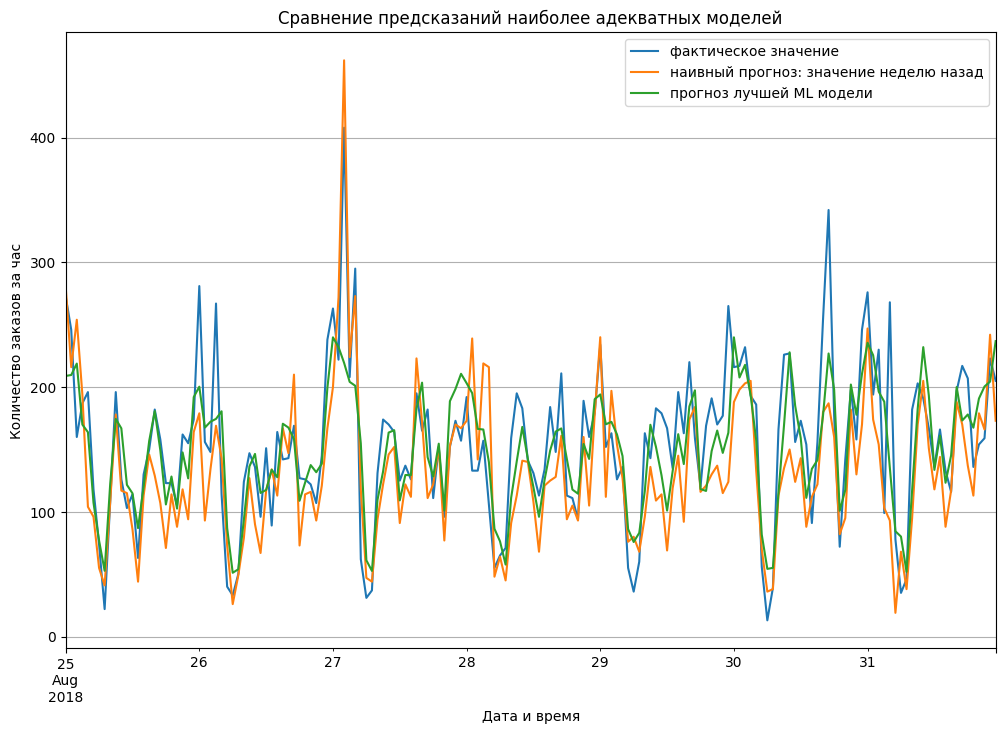

In [73]:
# значение метрики RMSE лучшей "наивной" модели
min_naive_test_score = min(naive_test_scores)

# предсказания лучшей "наивной" модели
best_naive_predictions = pd.Series(
    naive_predictions[naive_test_scores.index(min_naive_test_score)]
)

# ограничение временного периода
dt_range_mask = y_test.index >= '2018-08-25'

# создаём область построения графиков
plt.figure(figsize=(12, 8))

# строим графики:
# фактические значения ряда
ax = y_test[dt_range_mask].plot()

# предсказания лучшей "наивной" модели
best_naive_predictions[dt_range_mask].plot(ax=ax)

# предсказания лучшей ML модели
y_pred[dt_range_mask].plot(ax=ax)

# оформляем график
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов за час')
plt.title('Сравнение предсказаний наиболее адекватных моделей')
plt.legend([
    'фактическое значение', 
    'наивный прогноз: значение неделю назад',
    'прогноз лучшей ML модели'
])
plt.grid()

Используемая для оценки качества предсказаний моделей метрика RMSE сильнее штрафует модель за большие ошибки. Поэтому можно предположить, что метрика лучшей ML модели LightGBM на тестовой выборке получилась существенно больше  из-за того, что модель хуже предсказывает пиковые значения количества заказов.

### Анализ остатков

Сравним предсказания лучшей модели $y_{pred}$ с истинными значениями $y_{true}$ целевого признака в тестовой выборке. Для этого исследуем совместное распределение предсказанного и истинного значений на диаграмме рассеяния. Для идеальной модели все точки должны лежать на диагональной линии $y_{pred} = y_{true}$.

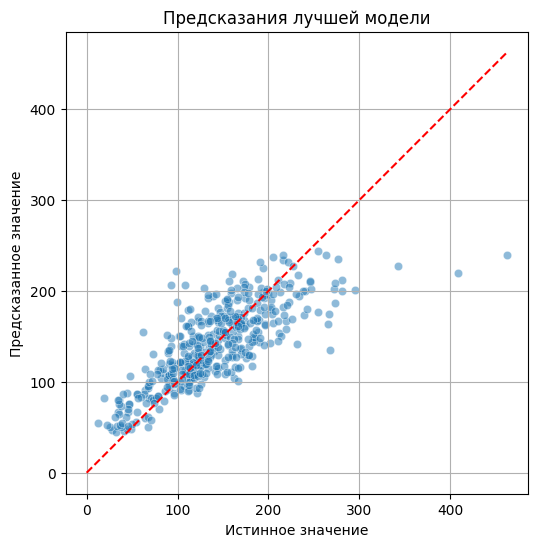

In [74]:
# создаём область построения графиков
plt.figure(figsize=(6, 6))

# строим диаграмму рассеяния
ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
# проводим пунктирную диагональную линию
ax.plot([0, y_test.max()], [0, y_test.max()], 'r--')

# оформляем график
ax.set_xlabel('Истинное значение')
ax.set_ylabel('Предсказанное значение')
ax.set_title('Предсказания лучшей модели')
ax.grid()
ax.set_aspect('equal')

По графику видно, что модель плохо предсказывает редкие большие значения. А метрика RMSE как раз сильнее штрафует модель за большие ошибки. 

Для более подробного анализа проведём анализ остатков модели на тестовой выборке. Это поможет оценить стабильность и устойчивость предсказаний модели. Используем пользовательскую функцию `plot_residuals`. 

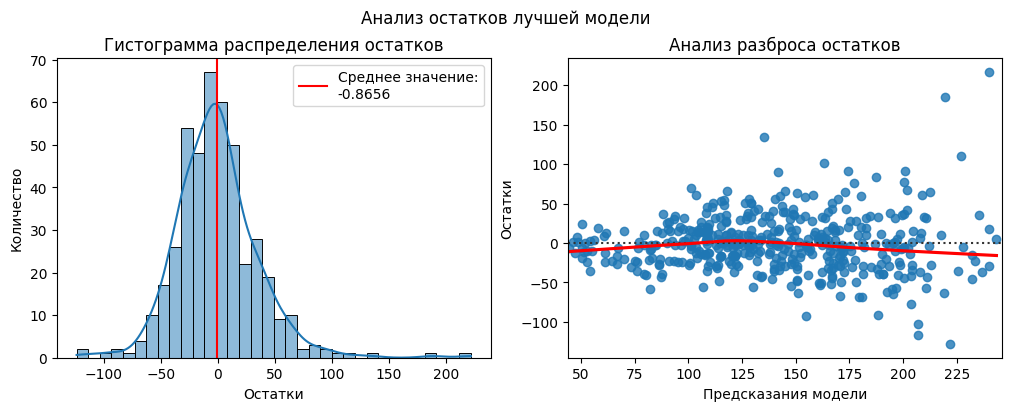

In [75]:
# строим графики для анализа остатков
fig, _ = plot_residuals(y_test, y_pred)
fig.suptitle('Анализ остатков лучшей модели');

Анализ остатков показывает:
- Распределение остатков похоже на нормальное и почти симметрично относительно нуля, значит модель ошибается в среднем равномерно и  работает стабильно.
- В остатках имеются отдельные выбросы, причём большие ошибки предсказаний получаются для больших значений целевого признака.
- Разброс остатков выше для больших значений целевого признака. Это указывает на потенциальную проблему с устойчивостью предсказаний модели для больших значений целевого признака.

Как было установлено, во временном ряде есть возрастающий тренд и его дисперсия тоже возрастает со временем. А модель обучалась на данных, предшествующих тестовым. Поэтому проблема неравномерной дисперсии остатков тоже, вероятно, обусловлена нестационарностью временного ряда.

### Анализ важности признаков

У модели LightGBM, также как и у дерева решений, есть встроенное средство оценки важности признаков — атрибут `feature_importances_`. Однако он не позволяет оценить направленность влияния прогнозирующих признаков на целевой. Чтобы получить такую информацию, исследуем влияние значений признаков на предсказания модели средствами библиотеки **SHAP**. 

Для объяснения предсказаний модели LightGBM подойдёт класс `shap.TreeExplainer`.

In [76]:
# инициализируем объект explainer
shap_explainer = shap.TreeExplainer(best_model, 
                                    feature_perturbation='tree_path_dependent')

# вычисляем значения Шепли для тестовой выборки
shap_values = shap_explainer(X_test)

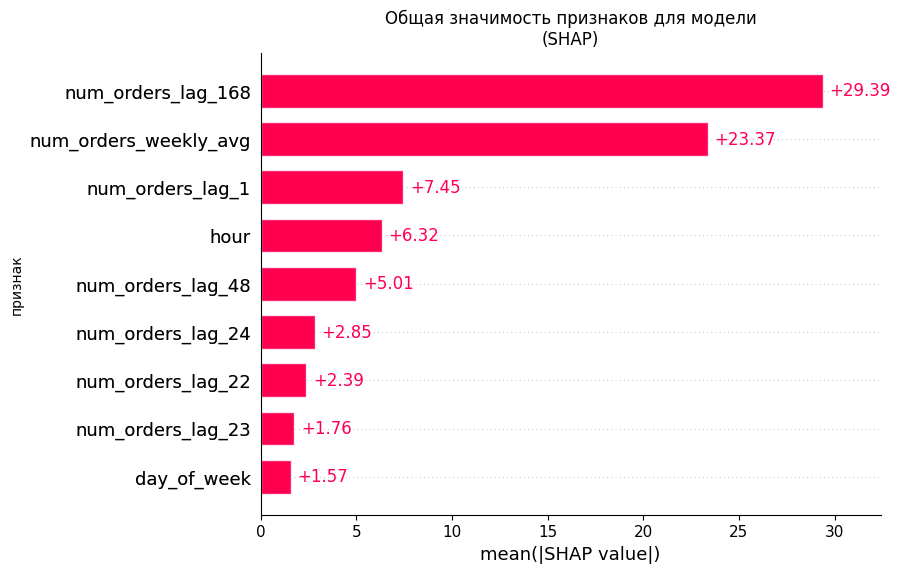

In [77]:
# строим график общей значимости признаков
shap.plots.bar(shap_values, max_display=len(X_test.columns), show=False) 

# оформляем график
plt.ylabel('признак')
plt.title('Общая значимость признаков для модели\n(SHAP)');

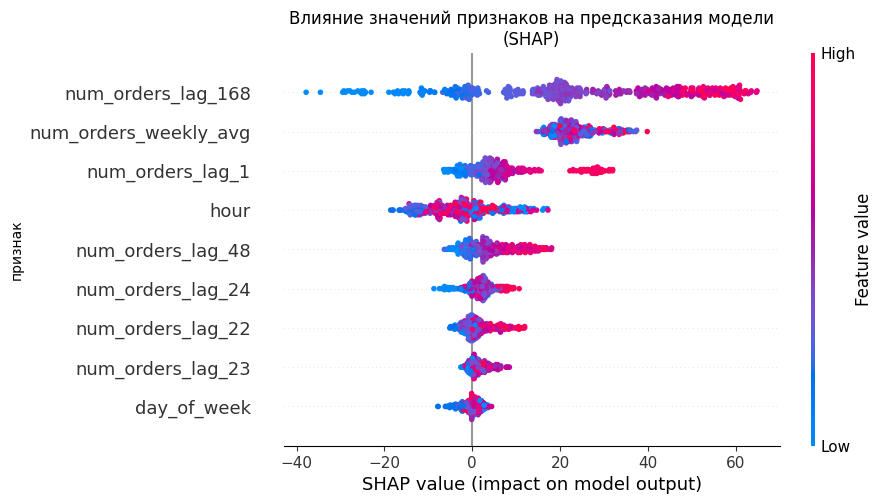

In [78]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака
shap.plots.beeswarm(shap_values, max_display=len(X_test.columns), show=False)

# оформляем график
plt.ylabel('признак')
plt.title('Влияние значений признаков на предсказания модели\n(SHAP)');

Анализ влияния значений признаков на предсказания модели показывает:
- Наиболее значимый для модели признак `num_orders_lag_168` — это количество заказов такси в это же время неделю назад. Это закономерно, учитывая, что из "наивных" моделей наилучшее качество показала модель, предсказывающая значение временного ряда равным его значению неделю назад.

- Значимость признака `num_orders_weekly_avg` (скользящее среднее количества заказов за неделю) тоже значительна. Строго положительное влияние признака на предсказания модели на тестовой выборке соответствует тому, что временной ряд имеет восходящий тренд.

- Направленность влияния всех запаздывающих признаков на предсказания модели положительная, что тоже согласуется с результатами исследования автокорреляции временного ряда.

- Признак "час" имеет среднюю значимость. Направленность влияния признака на предсказания модели соответствует тому, что в ночные часы заказов такси меньше, как и было установлено на этапе анализа данных.

- Признак "день недели" имеет низкую значимость и слабо выраженную направленность, которая объясняется тем, что зависимость количества заказов от для недели немонотонная.

### Выводы

1. Выбранная лучшая ML модель — оптимизированная модель LightGBM, показавшая наилучшее качество на валидационной выборке, обучена на полной обучающей выборке (т.е. объединении обучающей и валидационной выборок).

2. **Качество** лучшей ML модели проверено на тестовой выборке.
    - Значение метрики RMSE на тестовой выборке удовлетворяет заданному требованию: RMSE = 36.15 < 48. Однако качество модели на тестовой выборке оказалось значительно хуже, чем было на валидационной (RMSE = 5.48). Причина этого в нестационарности прогнозируемого временного ряда, вследствие чего статистические характеристики валидационной и тестовой выборок оказываются различны. Поэтому реальное качество модели в данной задаче прогнозирования значений нестационарного временного ряда невозможно установить путём её предварительной проверки на валидационной выборке.

3. Лучшая ML модель проверена на **адекватность** путём сравнения качества её предсказаний с предсказаниями "наивных" моделей, которые предсказывают значения временного ряда равными его значениям в предшествующие моменты времени или их агрегатам (например, скользящему среднему значению).
    - Лучшая из "наивных" моделей, предсказания которой равны значениям ряда 168 ч (1 неделю) назад, показала значение метрики RMSE на тестовой выборке 39.55. Поэтому построенную ML модель можно считать адекватной.
    - Причина высокого качества предсказаний "наивной" модели, предсказания которой равны значениям ряда неделю назад, заключается в наличии сильной недельной сезонности в данных.  

4. Для лучшей ML модели проведён анализ остатков и анализ важности признаков.
    - **Анализ остатков** показал:
        - Модель в целом предсказывает нормально, но плохо предсказывает редкие большие значения. А метрика RMSE как раз сильнее штрафует модель за большие ошибки. 
        - Модель ошибается в среднем равномерно и  работает стабильно, поскольку распределение остатков похоже на нормальное и симметрично относительно нуля.
        - Существует потенциальная проблема с устойчивостью предсказаний модели для больших значений целевого признака, поскольку разброс остатков выше для больших значений целевого признака. Проблема неравномерной дисперсии остатков тоже обусловлена нестационарностью временного ряда — наличием возрастающего тренда и возрастанием его дисперсии со временем. А модель обучалась на данных, хронологически предшествующих тестовым.
  
    - **Анализ важности признаков** и характера их влияния на предсказания модели показал:
        - Наиболее значимый для модели признак — количество заказов такси в это же время неделю назад.
        - Значимость скользящего среднего количества заказов за неделю тоже значительна.
        - Значимость циклических календарных признаков для модели невысокая, направленность их влияния соответствует результатам анализа данных.

## Общий вывод

1. В проекте была поставлена **задача** на основании исторических данных о заказах такси в аэропортах построить модель для предсказания количества заказов такси на следующий час, чтобы компания-заказчик знала, когда нужно привлекать больше водителей в период пиковой нагрузки.
    - Требования к модели: значение метрики RMSE на тестовой выборке размером 10% от исходных данных должно быть не больше 48.
  
2. **Исходный датасет** содержит данные о количестве заказов такси в течение каждых 10 минут за полгода, с начала марта по конец августа 2018 года включительно. Дубликаты, пропущенные и аномальные значения в данных отсутствуют.

3. Выполнено **ресемплирование** данных по одному часу. В результате получен временной ряд с суммарным количеством заказов за каждый час за период с 0 часов 1 марта по 23 часа 31 августа 2018 года включительно.

4. Проведён **анализ** временного ряда.
    - Исследуемый временной ряд — **нестационарный**.  У временного ряда имеется **нарастающий тренд** — рост со временем среднего значения. Стандартное отклонение значений ряда тоже возрастает со временем.
    - Выявлены **сезонные компоненты** временного ряда с периодом 1 сутки (24 часа) и 1 неделя (168 часов). Исследование сезонности помогло выбрать оптимальный период усреднения для расчёта скользящего среднего — 1 неделю как максимальный период сезонности временного ряда.
    - Исследование **частичной автокорреляции** временного ряда помогло выбрать наиболее релевантные запаздывающие признаки для прогнозирования будущих значений ряда, которые сильнее всего коррелируют с текущим значением ряда.

5. Выполнена **подготовка данных** для обучения и оценки качества моделей.
    - К данным добавлены прогнозирующие признаки, по которым ML модель будет предсказывать значения временного ряда:
        - календарные признаки: день недели и час, которые позволят учесть выявленную суточную и недельную сезонность временного ряда. 
        - скользящее среднее значение количества заказов в час за период предшествующих 7 суток (168 часов), которое позволит учесть тренд временного ряда.
        - запаздывающие признаки — значения количества заказов в час с лагом 1 час, 22 и 23 часа, 1 сутки (24 часа), 2 суток (48 часов) и 1 неделя (168 часов).

    - Данные разделены на обучающую, валидационную и тестовую выборки с выделением целевого признака (количества заказов такси за час) в отдельную переменную. Размеры тестовой и валидационной выборки одинаковы и составляют по 10% от исходных данных. 

    - Анализ корреляций между признаками, проведённый отдельно для каждой из выборок, показал, что коэффициенты корреляции между признаками в данных значительно варьируются для разных выборок. Статистические характеристики обучающей, валидационной и тестовой выборок оказываются различны из-за нестационарности временного ряда.

6. Для сравнения выбраны **ML модели** 5 классов:
    - простая линейная регрессия;
    - модель опорных векторов (SVM) с ядром радиальной базисной функции (RBF) и ослабленной регуляризацией;
    - модель дерева решений со значениями гиперпараметров, ограничивающих рост дерева;
    - модель случайного леса, использующая только 2 случайно выбранных признака для каждого дерева;
    - оптимизированная модель градиентного бустинга на деревьях решений LightGBM.

   Для моделей, имеющих настраиваемые гиперпараметры, сделана попытка подбора их оптимальных значений исходя из принципа минимизации метрики RMSE на валидационной выборке.

7. Проведено сравнение качества предсказаний моделей на валидационной выборке после обучения модели на обучающей выборке. В результате **выбрана лучшая модель**, которая показала наилучшее качество на валидационной выборке — оптимизированная модель LightGBM. 

8. **Качество** лучшей ML модели LightGBM проверено на тестовой выборке после обучения модели на полной обучающей выборке (т.е. объединении обучающей и валидационной выборок).
    - Значение метрики RMSE на тестовой выборке удовлетворяет заданному требованию: RMSE = 36.15 < 48.
    - Качество модели на тестовой выборке оказалось значительно хуже, чем на валидационной. Из-за нестационарности временного ряда реальное качество прогнозирующей модели оказалось невозможно объективно установить путём предварительной проверки на валидационной выборке.

9. Лучшая ML модель проверена на **адекватность** путём сравнения качества её предсказаний с предсказаниями "наивных" моделей, которые предсказывают значения временного ряда равными его значениям в предшествующие моменты времени или их агрегатам.
    - Лучшую ML модель можно считать адекватной, потому что она показала качество выше, чем у всех рассмотренных "наивных" моделей. Однако у "наивной" модели, предсказания которой равны значениям ряда 1 неделю назад, качество оказалось не сильно хуже: значение метрики RMSE на тестовой выборке всего лишь на 8.6 % больше. Вероятная причина этого в наличии сильной недельной сезонности в данных.

10. Для выбранной лучшей ML модели проведён анализ остатков и анализ важности признаков.
    - **Анализ остатков** показал, что модель в целом предсказывает нормально, но плохо предсказывает редкие большие значения. 
        - Модель ошибается в среднем равномерно и  работает стабильно.
        - Существует потенциальная проблема с устойчивостью предсказаний модели для больших значений целевого признака из-за неравномерности дисперсии остатков, которая обусловлена нестационарностью временного ряда.
  
    - **Анализ важности признаков** и характера их влияния на предсказания модели показал:
        - Наиболее значимый для модели признак — количество заказов такси в это же время неделю назад. Значимость скользящего среднего количества заказов за сутки тоже значительна, но влияние сезонности и случайных флуктуаций оказываются сильнее, чем общий тренд.
        - Значимость циклических календарных признаков для модели невысокая, направленность их влияния соответствует результатам анализа данных.

**Итоговые выводы по применению ML моделей для прогнозирования временных рядов:**
- Из рассмотренных ML моделей лучше всего с задачей прогнозирования значений временного ряда справляется модель градиентного бустинга LightGBM, использующая запаздывающие признаки — значения ряда в предшествующие моменты времени, и скользящее среднее значение. Отбор наиболее релевантных запаздывающих признаков следует производить на основе анализа автокорреляционной функции временного ряда.
- Поиск оптимальных значений гиперпараметров моделей на валидационной выборке в случае нестационарности временного ряда может быть не эффективен.
- Реальное качество модели в задаче прогнозирования нестационарного временного ряда невозможно установить путём её предварительной проверки на валидационной выборке, которая должна хронологически предшествовать тестовой.
- Дальнейшие возможные направления исследований с целью повышения качества прогноза:
    - Выбор прогнозирующей ML модели другого типа, менее склонной к переобучению, например, простой линейной регрессии.
    - Определение минимального набора прогнозирующих признаков, при обучении на которых модель обеспечивает целевое значение метрики.
    - Проверка гипотезы, поможет ли предварительное приведение ряда к стационарному путём преобразований (логарифмирование, дифференцирование и т.д.) повысить качество прогнозирующей модели.
    - Учёт разложения на тренд и сезонную компоненту при построении прогнозирующей модели. Например, прогнозировать тренд, а сезонность брать из исторических данных.

**Итоговые выводы для бизнеса:**
- Построенная ML модель обеспечивает точность прогноза количества заказов такси в час лучше заданного уровня: значение метрики RMSE (среднеквадратичная ошибка прогноза) на тестовой выборке меньше 48.
- При использовании построенной ML модели точность предсказания количества заказов такси в час возросла по сравнению с "наивным" прогнозом (значение в это же время неделю назад): значение метрики RMSE (среднеквадратичная ошибка прогноза) на тестовой выборке снизилось на 8.6 %.
- Простая "наивная" прогнозирующая модель, которая предсказывает количества заказов такси в час таким же, как в это же время неделю назад, показала результат не намного хуже построенной ML модели. А делать такой прогноз намного проще и быстрее, поскольку нет нужды в обучении ML модели.
- Для поддержания качества прогнозов ML модели на приемлемом уровне необходимо регулярно обучать её на свежих данных.
- Для лучшего учёта вариаций спроса на такси в выходные и праздничные дни желательно предоставить информацию о локации, для которой нужно сделать прогноз (страна, регион).